## Project DSI 311 

รายชื่อสมาชิก    
นันทกร เนคะมานุรักษ์ 6624650013  
ปัณณธร ดำรงวุฒิ 6624650070  
พีรวัส ปุ้ยพันธวงศ์ 6624650385  
ชยุต มีคุณ 6624650195  
ภูดิส ปรีชาพลกุล 6624650443  

## Data understaning
ชื่อชุดข้อมูล : Chest X-Ray Images (Pneumonia)  
แหล่งที่มา : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia  
ชุดข้อมูลนี้เป็นโจทย์เกี่ยวกับ Classification การจำแนกประเภทปอดอักเสบและปอดปกติ ซึ่งเหมาะกับ ML Task ที่ได้รับ

ชุดข้อมูลนี้ประกอบด้วยภาพเอกซเรย์ทรวงอกเด็กจำนวน 5,863 ภาพ แบ่งออกเป็นสองประเภทคือ Pneumonia และ Normal ซึ่งภายในประกอบด้วยโฟลเดอร์ย่อยตามหมวดหมู่ของภาพ ภาพทั้งหมดถูกรวบรวมจากผู้ป่วยเด็กอายุ 1–5 ปี ที่เข้ารับการตรวจรักษาตามปกติที่ Guangzhou Women and Children’s Medical Center เมืองกวางโจว ประเทศจีน ก่อนนำมาใช้ ภาพถูกตรวจสอบคุณภาพและคัดทิ้งภาพที่ไม่ชัดเจนหรือใช้งานไม่ได้ จากนั้นแพทย์ผู้เชี่ยวชาญสองท่านร่วมกันให้การวินิจฉัยเพื่อกำหนดฉลากของภาพ   

ข้อมูลที่เตรียมให้  
train = 5,216  
test = 624  
val = 16  
  
เป้าหมายคือ ทำนายโรคปอดอักเสบและปอดที่เป็นปกติ  
0 = ปอดปกติ  
1 = ปอดอักเสบ  


## Library

In [149]:
# Python standard
import os
import zipfile
import random

# Data & utilities
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    recall_score, confusion_matrix, classification_report,
    roc_curve, auc
)

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Torchvision
from torchvision import transforms
from torchvision.models import resnet50

# Image processing
from PIL import Image
import cv2
import imagehash

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


## kaggle (Load data)

โหลดข้อมูลจาก kaggle และแตกไฟล์ (ใช้เวลานาน เพราะไฟล์ใหญ่ประมาณ 2 GB)

In [ ]:
# with open(".env") as f:
#     for line in f:
#         key, val = line.strip().split("=")
#         os.environ[key] = val

# # print("Kaggle user:", os.environ['KAGGLE_USERNAME'])  
# # print("Kaggle user:", os.environ['KAGGLE_KEY'])  

In [ ]:
# !mkdir -p Data
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p Data

In [ ]:
# with zipfile.ZipFile("Data/chest-xray-pneumonia.zip", "r") as zip_ref:
#     zip_ref.extractall("Data/")

## Data Preparation & Exploratory data analysis   


## 1) Pull data from folder
ดึงข้อมูลภาพจากโฟลเดอร์เก็บไฟล์ทั้งหมดไว้ใน DataFrame

In [39]:
def make_dataframe(base_dir):
    filepaths = []
    labels = []

    for split in ["train", "val", "test"]:
        for label_dir in ["NORMAL", "PNEUMONIA"]:
            path = os.path.join(base_dir, split, label_dir)
            for filename in os.listdir(path):
                filepaths.append(os.path.join(path, filename))
                labels.append(0 if label_dir == "NORMAL" else 1)

    df = pd.DataFrame({
        "filepath": filepaths,
        "label": labels
    })
    return df

base_dir = "Data/chest_xray" # Your path
df_all = make_dataframe(base_dir)
print(len(df_all))
df_all['label'].value_counts()

5856


label
1    4273
0    1583
Name: count, dtype: int64

ข้อมูลมีทั้งหมด 5856 ภาพ  
ภาพที่เป็นโรคปอดอักเสบมีทั้งหมด 4273 ภาพ  
ภาพที่เป็นโรคปอดปกติมีทั้งหมด 1583 ภาพ  


## 2) Image size
ตรวจสอบขนาดรูป (width × height) ของภาพ X-ray ทุกภาพใน DataFrame เพื่อดูว่าภาพมีขนาดเท่ากันหรือไม่ และดูว่ามีขนาดรูปภาพที่ผิดปกติหรือไม่

In [40]:
widths = []
heights = []

for path in tqdm(df_all["filepath"], desc="Checking image sizes"):
    try:
        with Image.open(path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except:
        widths.append(None)
        heights.append(None)

df_all["width"] = widths
df_all["height"] = heights

print("Image Size Summary (pixels)")
display(df_all[["width", "height"]].describe().round(1))


Checking image sizes: 100%|██████████| 5856/5856 [00:02<00:00, 2728.06it/s]

Image Size Summary (pixels)


width  height
count  5856.0  5856.0
mean   1327.9   970.7
std     363.5   383.4
min     384.0   127.0
25%    1056.0   688.0
50%    1281.0   888.0
75%    1560.0  1187.0
max    2916.0  2713.0

Most common image sizes:
Distribution โดยรวม


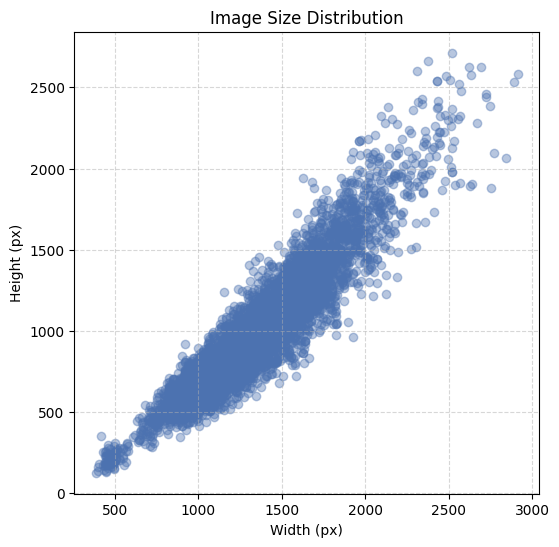

In [41]:
mode_size = df_all.groupby(["width", "height"]).size().reset_index(name="count").sort_values("count", ascending=False)
print("Most common image sizes:")
# display(mode_size.head())

print("Distribution โดยรวม")
plt.figure(figsize=(6,6))
plt.scatter(df_all["width"], df_all["height"], alpha=0.4, color="#4C72B0")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Image Size Distribution")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


จากกราฟจะเห็นได้ว่า Width, Height ที่ช่วง 0 - 500 มีข้อมูลเกาะกลุ่มกันจึงทำการสำรวจเพิ่มเติมว่า ภาพที่มีความสูงความกว้างที่น้อยมีภาพเป็นอย่างไร

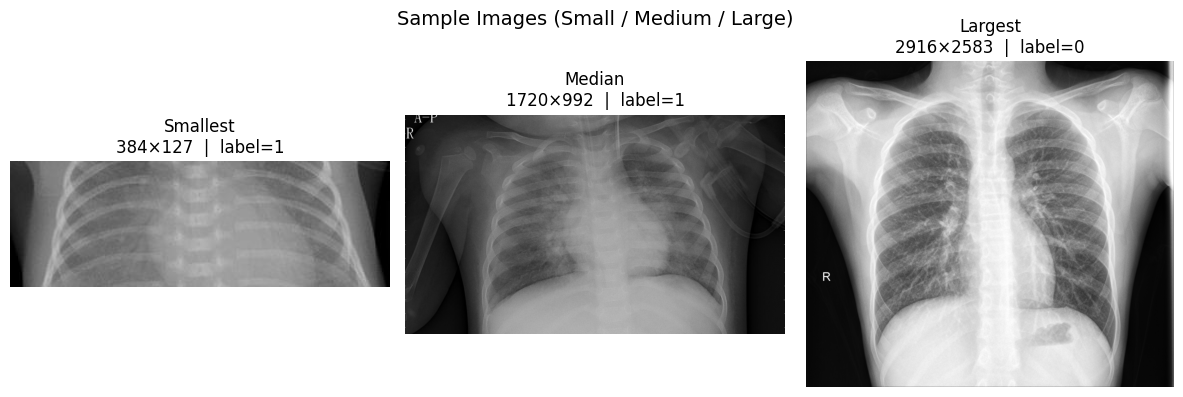

In [42]:
smallest = df_all.sort_values(by=["width", "height"]).iloc[0]
median = df_all.iloc[len(df_all)//2]
largest = df_all.sort_values(by=["width", "height"], ascending=False).iloc[0]

samples = [("Smallest", smallest), ("Median", median), ("Largest", largest)]

plt.figure(figsize=(12,4))

for i, (title, row) in enumerate(samples):
    plt.subplot(1, 3, i+1)
    img = Image.open(row["filepath"])
    plt.imshow(img, cmap='gray')
    plt.title(f"{title}\n{row['width']}×{row['height']}  |  label={row['label']}")
    plt.axis("off")

plt.suptitle("Sample Images (Small / Medium / Large)", fontsize=14)
plt.tight_layout()
plt.show()

เมื่อได้สำรวจขนาดเล็ก กลาง และใหญ่แล้วพบว่า ภาพที่เป็นขนาดกลางและเล็กเหมือนจะเป็นภาพที่ทำการ Crop มาในขั้นตอนถัดไปจะดูว่าแล้วภาพที่เป็นขนาดเล็กมีภาพลักษณ์เป็นอย่างไรบ้างเพื่อตัดสินใจว่าจะทำการ ลบหรือไม่

พบภาพที่ความสูง < 300 px ทั้งหมด 76 ภาพ


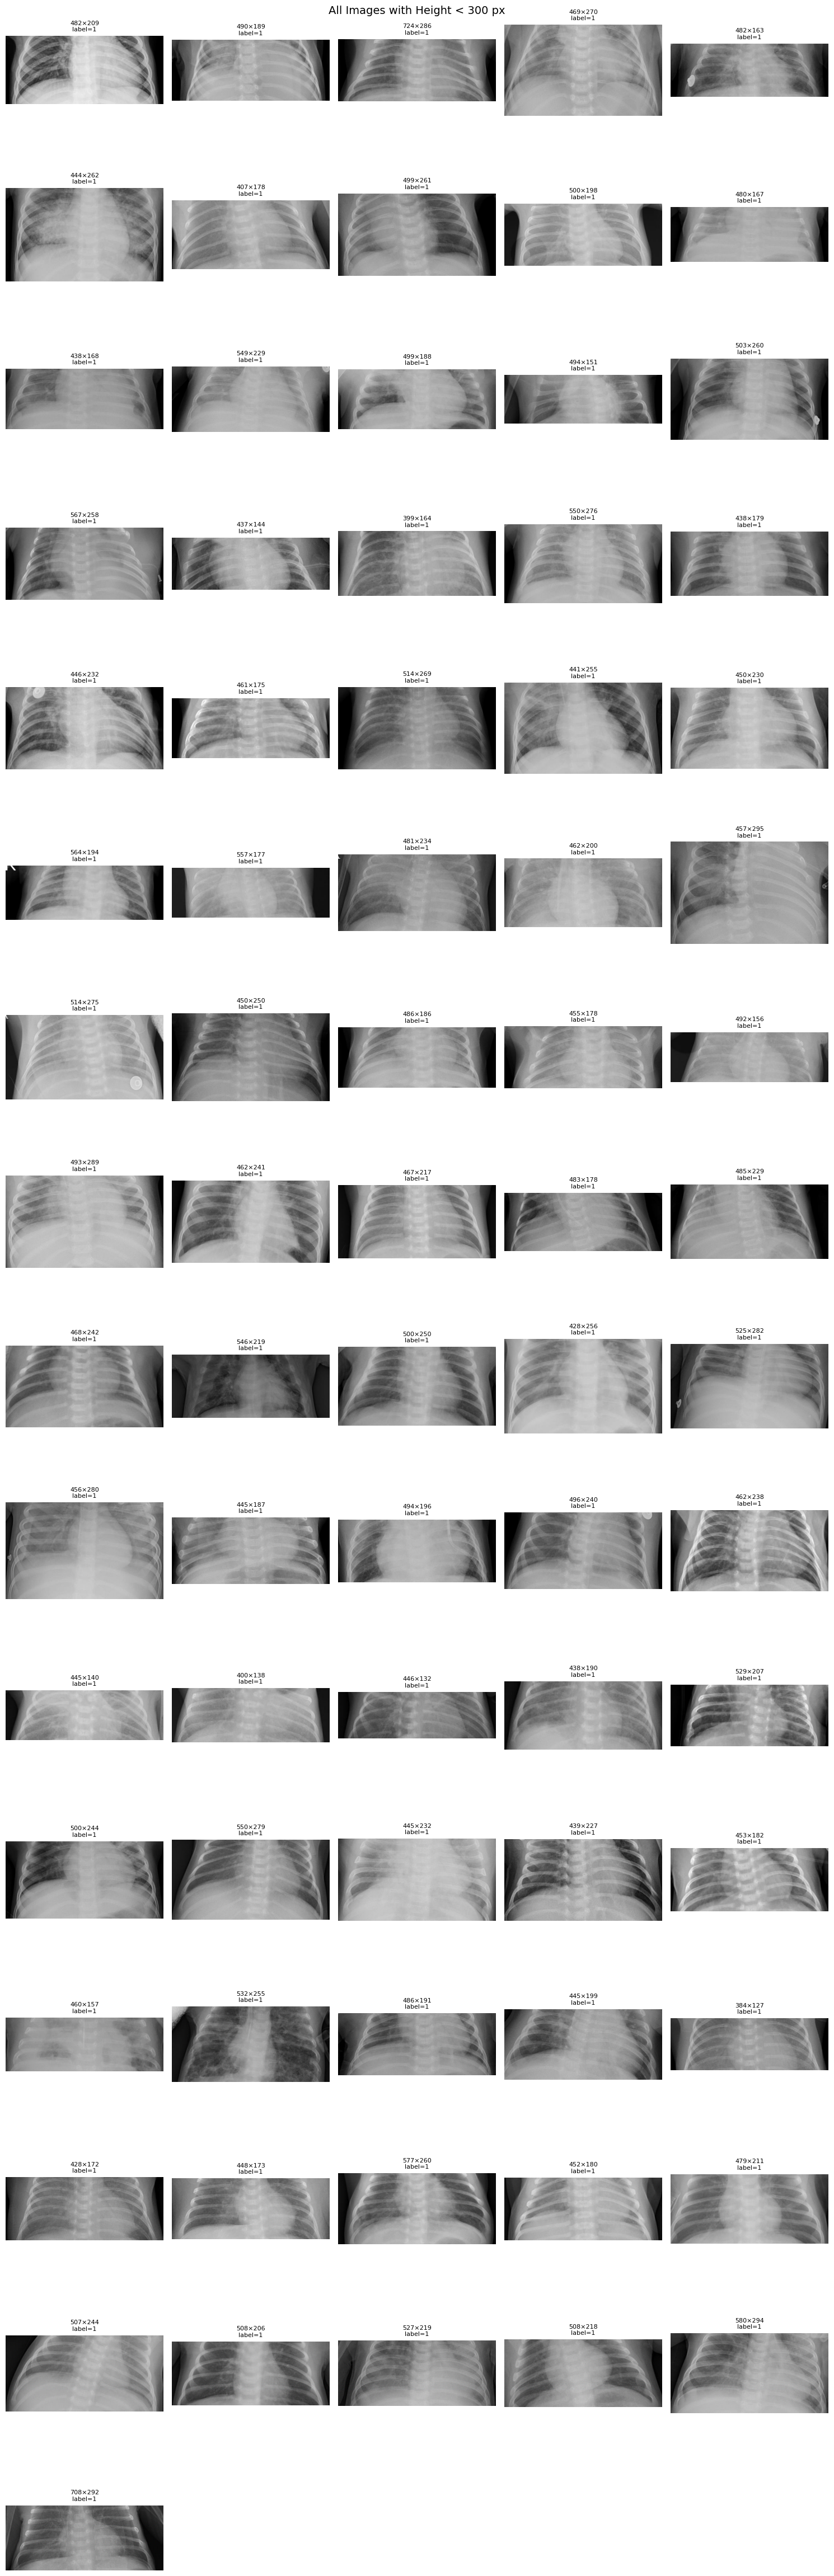

In [26]:
small_imgs = df_all[df_all["height"] < 300]

print(f"พบภาพที่ความสูง < 300 px ทั้งหมด {len(small_imgs)} ภาพ")
n = len(small_imgs)
cols = 5
rows = (n // cols) + 1

plt.figure(figsize=(15, 3 * rows))
for i, (_, row) in enumerate(small_imgs.iterrows()):
    plt.subplot(rows, cols, i+1)
    try:
        img = Image.open(row["filepath"])
        plt.imshow(img, cmap="gray")
        plt.title(f"{row['width']}×{row['height']}\nlabel={row['label']}", fontsize=8)
        plt.axis("off")
    except Exception as e:
        plt.text(0.5, 0.5, "Error", ha="center", va="center")
        plt.axis("off")

plt.suptitle("All Images with Height < 300 px", fontsize=14)
plt.tight_layout()
plt.show()


หลังจากที่ได้สำรวจภาพที่เหมือนจะโดน Crop พบว่าภาพที่ Crop มีประมาณ 76 ภาพในบริเวณช่วงปอด ซึ่งก็ยังคงความสำคัญของภาพไว้อยู่เพราะว่า โรคปอดอักเสบจะมี pattern ในช่วงอกดังนั้นอาจจะไม่จำเป็นต้องตัดออก

## 3) check duplicate image

In [43]:
def compute_phash(path):
    try:
        img = Image.open(path)
        return str(imagehash.phash(img))
    except:
        return None

df_all["phash"] = [
    compute_phash(fp.replace("\\", "/")) for fp in tqdm(df_all["filepath"])
]
df_all


100%|██████████| 5856/5856 [00:36<00:00, 159.00it/s]


filepath  label  width  height  \
0        Data/chest_xray\train\NORMAL\IM-0115-0001.jpeg      0   2090    1858   
1        Data/chest_xray\train\NORMAL\IM-0117-0001.jpeg      0   1422    1152   
2        Data/chest_xray\train\NORMAL\IM-0119-0001.jpeg      0   1810    1434   
3        Data/chest_xray\train\NORMAL\IM-0122-0001.jpeg      0   1618    1279   
4        Data/chest_xray\train\NORMAL\IM-0125-0001.jpeg      0   1600    1125   
...                                                 ...    ...    ...     ...   
5851  Data/chest_xray\test\PNEUMONIA\person96_bacter...      1   1120     856   
5852  Data/chest_xray\test\PNEUMONIA\person96_bacter...      1   1064     856   
5853  Data/chest_xray\test\PNEUMONIA\person97_bacter...      1   1400    1024   
5854  Data/chest_xray\test\PNEUMONIA\person99_bacter...      1   1264    1016   
5855  Data/chest_xray\test\PNEUMONIA\person99_bacter...      1   1704    1122   

                 phash  
0     8129ca38795979cf  
1     c06cc73ecc4f2dc1  
2     912fc74b98c93b92  
3     d07ac61a99ed3c94  
4     907ce73ead0f3824  
...                ...  
5851  946aeb3a0b1a19cf  
5852  946aaf1e011b78ed  
5853  913b4254545f7a5b  
5854  dd28e31f591d5c48  
5855  913def3e4b1b0849  

[5856 rows x 5 columns]

In [44]:
dup_df = df_all[df_all.duplicated("phash", keep='first')].copy()
dup_df = dup_df.sort_values("phash").reset_index(drop=True)


print("จำนวนภาพที่ซ้ำทั้งหมด:", len(dup_df))

จำนวนภาพที่ซ้ำทั้งหมด: 32


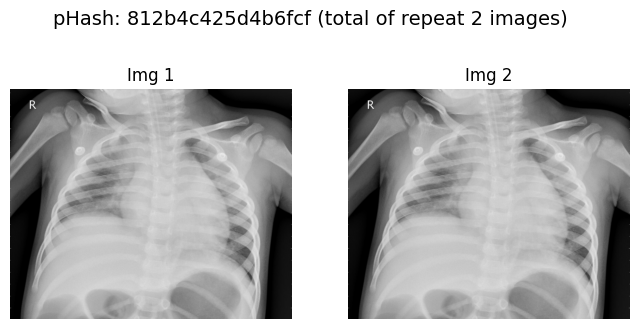

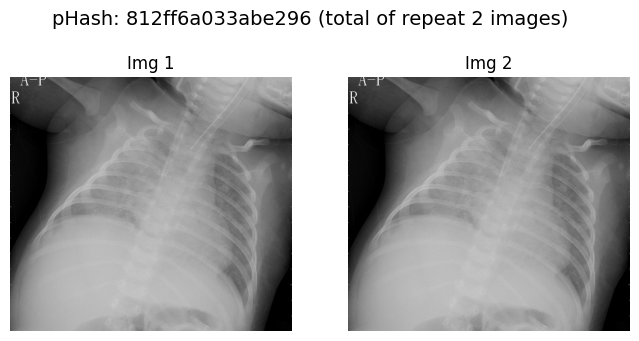

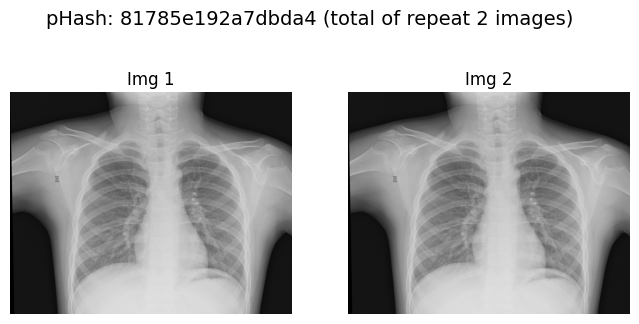

In [29]:
dup_df = df_all[df_all.duplicated("phash", keep=False)].copy()
dup_df = dup_df.sort_values("phash").reset_index(drop=True)
groups = dup_df.groupby("phash")["filepath"].apply(list)
first3 = list(groups.items())[:3]

for ph, filelist in first3:
    n = len(filelist)

    plt.figure(figsize=(4*n, 4))
    plt.suptitle(f"pHash: {ph} (total of repeat {n} images)", fontsize=14)

    for i, fp in enumerate(filelist):
        img = Image.open(fp.replace("\\", "/"))
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Img {i+1}")

    plt.show()


In [45]:
print("จำนวนรูปก่อนลบ:", len(df_all))

df_unique = df_all.drop_duplicates(subset="phash", keep="first").reset_index(drop=True)

print("จำนวนรูปหลังลบ:", len(df_unique))
print("จำนวนที่ถูกลบ:", len(df_all) - len(df_unique))
df_all = df_unique.copy()

จำนวนรูปก่อนลบ: 5856
จำนวนรูปหลังลบ: 5824
จำนวนที่ถูกลบ: 32


ภาพทั้งหมดตอนแรกมีทั้งหมด 5856 ภาพมีการใช้ pHash เพื่อทำการเช็คภาพที่ซ้ำกันผลสรุปคือ  
ผลจาก pHash เจอภาพซ้ำ 32 โดยไม่นับตัวแรกทำการลบภาพที่ซ้ำกันเหลือไว้ตัวแรก  
จำนวนรูปก่อนลบ: 5856  
จำนวนรูปหลังลบ: 5824  
จำนวนที่ถูกลบ: 32  

## 4) check channel of images 
ทำการเช็คว่าภาพทั้งหมดจาก Dataset มีภาพที่เป็น Grayscale และ RGB จำนวนเท่าไหร่ เนื่องจากใช้พิจารณาว่าภาพที่เป็น RGB และ Grayscale จะมองเห็น patternต่างกันอย่างไร และใช้พิจารณในการ input เข้า model

In [47]:
modes = []
for path in tqdm(df_all["filepath"], desc="Checking image color mode"):
    try:
        with Image.open(path) as img:
            modes.append(img.mode)
    except:
        modes.append(None)

df_all["mode"] = modes


print("Image Mode Summary:")
display(df_all["mode"].value_counts())


Checking image color mode: 100%|██████████| 5824/5824 [00:01<00:00, 3291.65it/s]

Image Mode Summary:


mode
L      5541
RGB     283
Name: count, dtype: int64

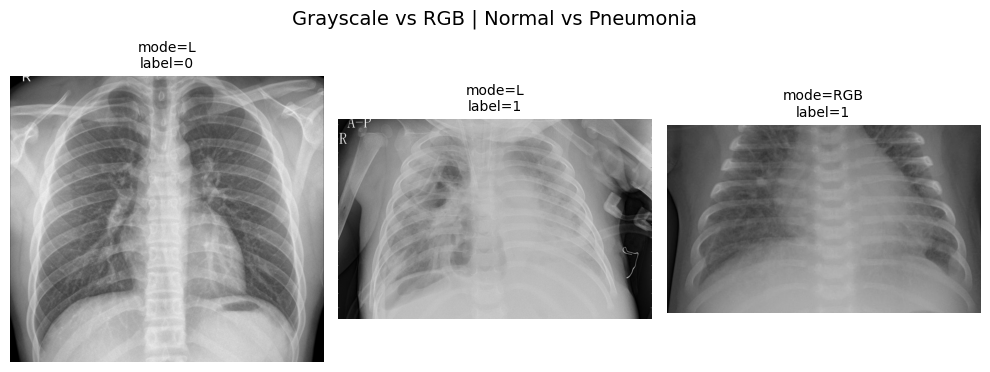

In [48]:
gray_normal     = df_all[(df_all["mode"] == "L")   & (df_all["label"] == 0)]
gray_pneumonia  = df_all[(df_all["mode"] == "L")   & (df_all["label"] == 1)]
rgb_normal      = df_all[(df_all["mode"] == "RGB") & (df_all["label"] == 0)]
rgb_pneumonia   = df_all[(df_all["mode"] == "RGB") & (df_all["label"] == 1)]

samples = pd.concat([
    gray_normal.sample(min(1, len(gray_normal)), random_state=123),
    gray_pneumonia.sample(min(1, len(gray_pneumonia)), random_state=4236),
    rgb_normal.sample(min(1, len(rgb_normal)), random_state=23412),
    rgb_pneumonia.sample(min(1, len(rgb_pneumonia)), random_state=222122),
])

plt.figure(figsize=(10, 4))
for i, (_, row) in enumerate(samples.iterrows()):
    img = Image.open(row["filepath"])
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap="gray" if row["mode"] == "L" else None)
    plt.title(f"mode={row['mode']}\nlabel={row['label']}", fontsize=10)
    plt.axis("off")

plt.suptitle("Grayscale vs RGB | Normal vs Pneumonia", fontsize=14)
plt.tight_layout()
plt.show()


จากภาพทั้งหมด มี    
Grayscale     5541  
RGB            283     
ภาพ RGB และภาพ Grayscale ก็มีความต่างกันไม่มากและภาพที่เป็น RGB จะมีเฉพาะในฝั่งของเป็นโรคปอดอักเสบ
ดังนั้นจะทำการแปลงเป็น RGB ทั้งหมดเนื่องจากการแปลงจาก Grayscale เป็น RGB ไม่ทำให้ข้อมูลเดิมเสียหายเป็นการเพิ่ม channel ขึ้นมาเป็น 3 channelและเหตุผลสำคัญคือ Model ที่จะนำมา train จะมี Resnet, ViT ซึ่งรองรับเฉพาะ RGB เท่านั้น 

แปลงภาพเป็น RGB ทั้งหมด

In [49]:
df_train = df_all[df_all["filepath"].str.contains("train")]
df_val = df_all[df_all["filepath"].str.contains("val")]
df_test = df_all[df_all["filepath"].str.contains("test")]

print("Updated dataset counts:")
print(f"All:   {len(df_all)}")
print(f"Train: {len(df_train)}")
print(f"Val:   {len(df_val)}")
print(f"Test:  {len(df_test)}")

Updated dataset counts:
All:   5824
Train: 5190
Val:   16
Test:  618


In [50]:
new_dir = "Data/chest_xray_new"
os.makedirs(new_dir, exist_ok=True)

all_paths = pd.concat([df_all, df_train, df_val, df_test])["filepath"].unique()

print(f"กำลังสร้างภาพ RGB ทั้งหมด {len(all_paths)} ไฟล์ ไปยัง: {new_dir}")

for path in tqdm(all_paths, desc="Converting to RGB (new folder)"):
    try:
        rel_name = os.path.basename(path)
        dst_path = os.path.join(new_dir, rel_name)

        with Image.open(path) as img:
            rgb_img = img.convert("RGB")
            rgb_img.save(dst_path)
    except Exception as e:
        print(f"Error converting {path}: {e}")

print("แปลงภาพทั้งหมดเป็น RGB และบันทึกใน Data/chest_xray_new เรียบร้อยแล้ว")


กำลังสร้างภาพ RGB ทั้งหมด 5824 ไฟล์ ไปยัง: Data/chest_xray_new


Converting to RGB (new folder):   0%|          | 0/5824 [00:00<?, ?it/s]

Converting to RGB (new folder): 100%|██████████| 5824/5824 [01:04<00:00, 89.72it/s] 

แปลงภาพทั้งหมดเป็น RGB และบันทึกใน Data/chest_xray_new เรียบร้อยแล้ว


In [51]:
def update_paths(df, new_dir):
    df = df.copy()
    df["filepath"] = df["filepath"].apply(lambda x: os.path.join(new_dir, os.path.basename(x)))
    return df

df_all_new  = update_paths(df_all, "Data/chest_xray_new")
df_train_new = update_paths(df_train, "Data/chest_xray_new")
df_val_new   = update_paths(df_val, "Data/chest_xray_new")
df_test_new  = update_paths(df_test, "Data/chest_xray_new")

df_train_new = df_train_new[~df_train_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)
df_val_new   = df_val_new[~df_val_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)
df_test_new  = df_test_new[~df_test_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)

# print("path ใน df_all, df_train, df_val, df_test")

# print("ตรวจสอบจำนวนไฟล์:")
# print(f"df_all_new  : {len(df_all_new)}")
# print(f"df_train_new: {len(df_train_new)}")
# print(f"df_val_new  : {len(df_val_new)}")
# print(f"df_test_new : {len(df_test_new)}")

## 5) Histogram   
การวิเคราะห์ว่า ภาพที่เป็นปอดอักเสบกับภาพที่เป็นปกติมีลักษณะต่างกันอย่างไร ด้วย Histogram คือการแปลงภาพเป็น grayscale ก่อนแล้วทำการดูว่า มันมีความต่างของ intensy ของสีต่างกันยังไง

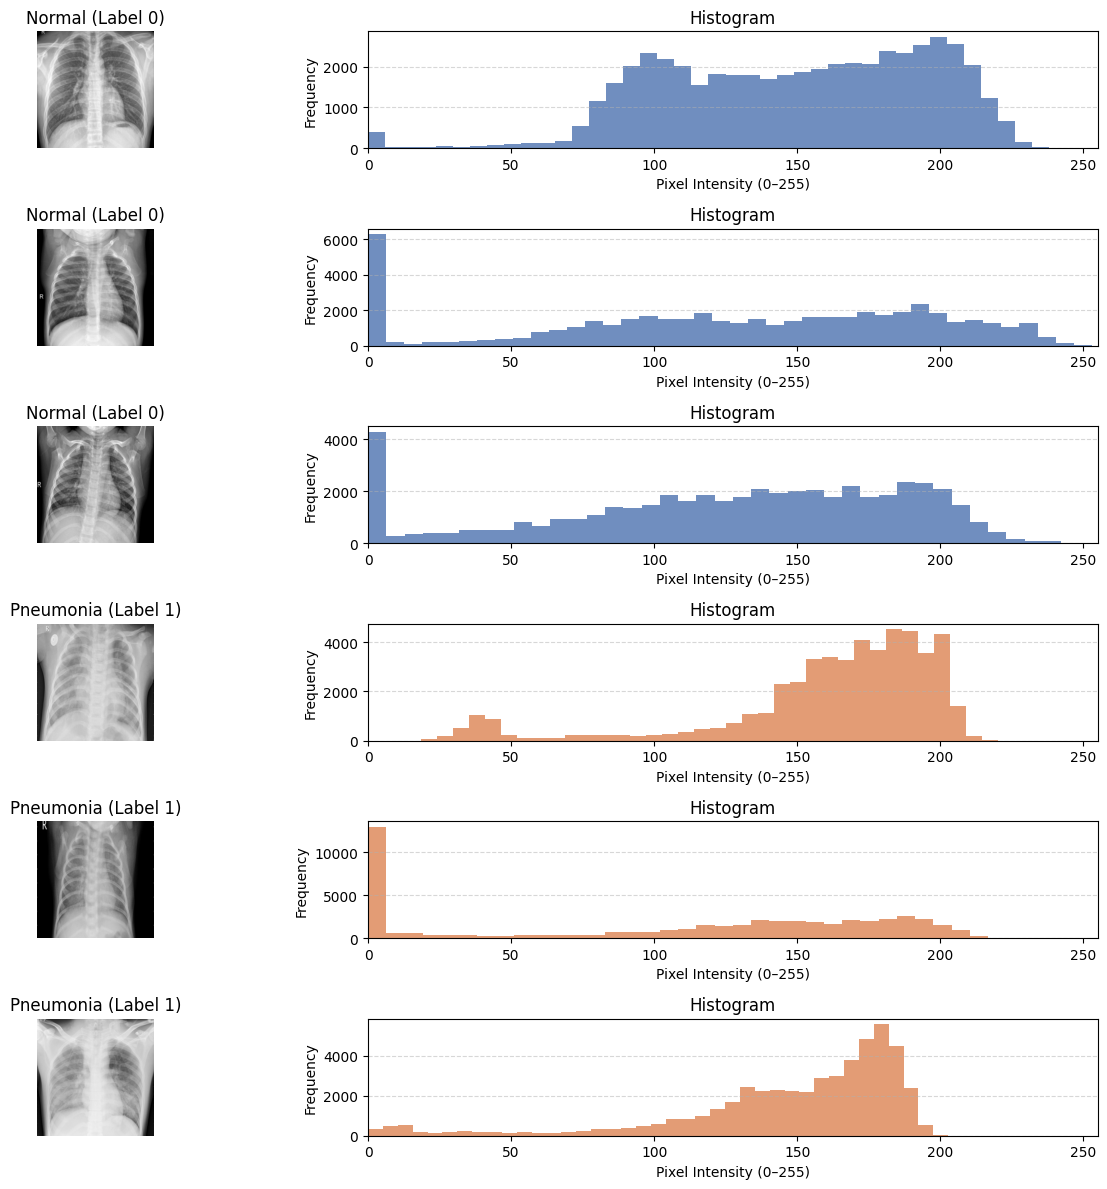

In [56]:
samples_0 = df_all_new[df_all_new["label"] == 0].sample(3, random_state=123)
samples_1 = df_all_new[df_all_new["label"] == 1].sample(3, random_state=23)

resize_size = (224, 224)
plt.figure(figsize=(14, 12))

def plot_image_and_hist(row, index, label_name, color):
    img = Image.open(row["filepath"]).convert("L").resize(resize_size)
    arr = np.array(img)

    plt.subplot(6, 2, 2*index - 1)
    plt.imshow(arr, cmap="gray")
    plt.title(f"{label_name} (Label {row['label']})", fontsize=12)
    plt.axis("off")

    plt.subplot(6, 2, 2*index)
    plt.hist(arr.ravel(), bins=40, color=color, alpha=0.8)
    plt.xlim(0, 255)  
    plt.xlabel("Pixel Intensity (0–255)", fontsize=10)
    plt.ylabel("Frequency", fontsize=10)
    plt.title("Histogram", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

for i, (_, row) in enumerate(samples_0.iterrows(), start=1):
    plot_image_and_hist(row, i, "Normal", "#4C72B0")

for i, (_, row) in enumerate(samples_1.iterrows(), start=4):
    plot_image_and_hist(row, i, "Pneumonia", "#DD8452")

plt.tight_layout()
plt.show()


จากกราฟจะเห็นว่า ภาพที่ป่วยเป็นปอดอักเสบ Histogram จะมีความเบ้ซ้ายคือ pixel ส่วนมากจะเอนเอี่ยงไปทางช่วง 200 เยอะแสดงถึงมีสีขาวเยอะ
แต่ก็มีบางภาพที่ label 1 คือปอดอักเสบแต่ว่าค่อนข้างมองด้วยตาเปล่ายาก คนทั่วไปอาจจะมองว่าเป็นปกติ เช่น ภาพ 4 มองเหมือนจะเป็นภาพปอดปกติไม่ค่อยมี ฝ้าขาวๆในช่วงปอดแต่ว่าก็เป็น ปอดอักเสบ

**6) Class distribution**

ดูว่า ภาพที่เป็นปอดปกติกับปอดอักเสบ มีจำนวนต่างกันอย่างไรเกิด class imbalance มั้ยและจะจัดการอย่างไร

Class Distribution by Dataset


label     0     1  Total  % Normal (0)  % Pneumonia (1)
All    1579  4245   5824          27.1             72.9
Train  1340  3850   5190          25.8             74.2
Val       8     8     16          50.0             50.0
Test    231   387    618          37.4             62.6

<Figure size 800x500 with 0 Axes>

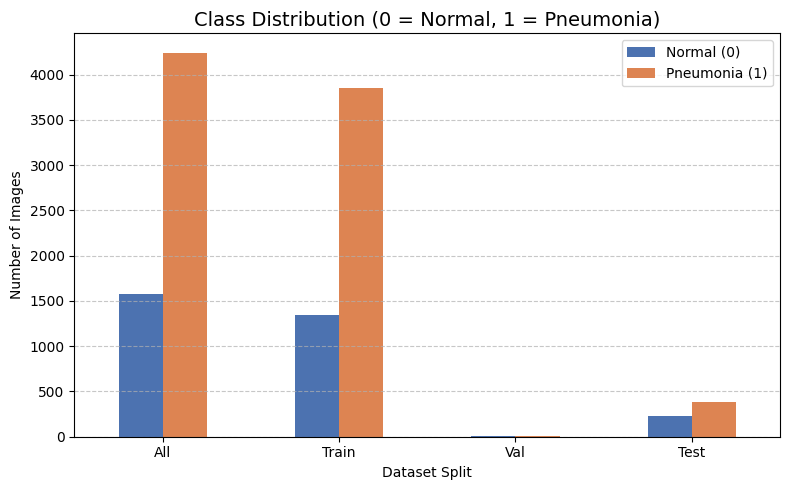

In [107]:
counts_train = df_train_new['label'].value_counts().sort_index()
counts_val = df_val_new['label'].value_counts().sort_index()
counts_test = df_test_new['label'].value_counts().sort_index()
counts_all = df_all_new['label'].value_counts().sort_index()

df_summary = pd.DataFrame({
    'All': counts_all,
    'Train': counts_train,
    'Val': counts_val,
    'Test': counts_test,

}).T.fillna(0).astype(int)

df_summary['Total'] = df_summary[0] + df_summary[1]
df_summary['% Normal (0)'] = (df_summary[0] / df_summary['Total'] * 100).round(1)
df_summary['% Pneumonia (1)'] = (df_summary[1] / df_summary['Total'] * 100).round(1)

print("Class Distribution by Dataset")
display(df_summary)

plt.figure(figsize=(8,5))
df_summary[[0,1]].plot(
    kind='bar',
    stacked=False,
    color=['#4C72B0', '#DD8452'],
    figsize=(8,5)
)
plt.title('Class Distribution (0 = Normal, 1 = Pneumonia)', fontsize=14)
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(['Normal (0)', 'Pneumonia (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


จากกราฟจะเห็นได้ว่าจากข้อมูลที่เขาแบ่งไว้ให้ ในส่วนของ validation, test ค่อนข้างมีจำนวนน้อยมากๆ เมื่อเทียบกับ train ดังนั้นก่อน train model จะมีการเพิ่ม sample ให้เยอะมากขึ้นแต่ยังคง sample ใน validation, test ที่ทางข้อมูล provide อยู่เพราะเป็นข้อมูลที่ทีมแพทย์ label มาให้เป็นการ top up จากเดิม  
 
และข้อมูลค่อนข้าง imbalance ในฝั่งของ Normal มีน้อยกว่า Pneumonia หรือปอดอักเสบมากๆ อาจจจะต้องทำ augmentation เพิ่มฝั่งของ normal ให้มีจำนวนใกล้เคียงกับ Pneumonia

โดยสรุป Preparation & EDA
ข้อมูล เริ่มต้นมี  
Train = 5,216    
Test = 624    
Val = 16    
Total = 5,856  

มีภาพซ้ำกัน 32 ภาพ
และภาพที่เป็น   
Grayscale  = 5,541     
RGB = 283      
 
โดยสรุปภาพหลังจากการทำ Preparation & EDA เหลือภาพทั้งหมด  
Train - 5,190  
Val =  16  
Test =  618  
total = 5,824

## Feature engineering

ทำการทำให้ภาพมีความคมชัดขึ้นตัดภาพส่วนที่เบลอๆ ออกด้วยเทคนิค CLAHE (Contrast Limited Adaptive Histogram Equalization)    
เบื้องหลังของ CLAHE คือ เทคนิคเพิ่มคอนทราสต์เฉพาะที่ ใช้ทำให้รายละเอียดในภาพมืดหรือหม่นดูชัดขึ้น    
เริ่มจากการทำภาพออกเป็นส่วนๆ grid เพราะมีความเชื่อว่าแต่ละมุมของภาพมี ความมืด ความสว่างต่างกัน    
จากนั้น แปลง Contrast แต่ละ block ที่แยก grid ออกมาเพื่อปรับ Contrast ทำให้แต่ละมุมมีการปรับเฉพาะส่วนมากขึ้น    
ดังนั้นมันจึงทำให้ภาพมีความสมจริง เป็น Contrast ที่สว่างจริงๆ มืดจริงๆ ทำให้เห็นรายละเอียดมากขึ้น   

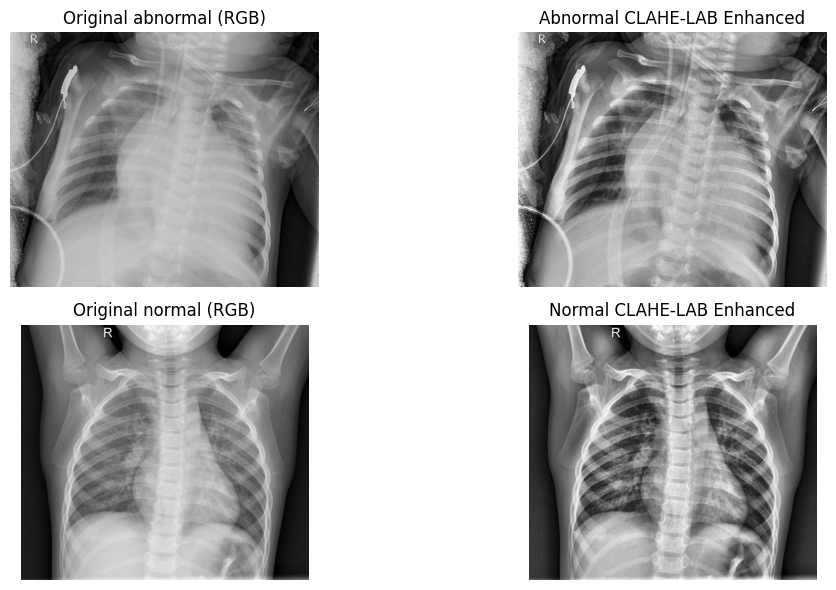

In [59]:
row = df_train_new.loc[1431]
path = row["filepath"].replace("\\", "/")
img = cv2.imread(path)                # BGR
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

row2 = df_train_new.loc[0]
path2 = row2["filepath"].replace("\\", "/")
img2 = cv2.imread(path2)              # BGR
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

def clahe_rgb(image_rgb):
    lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)

    lab2 = cv2.merge((l2, a, b))
    rgb2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
    return rgb2

img_clahe = clahe_rgb(img)
img_clahe2 = clahe_rgb(img2)

plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.imshow(img)
plt.title("Original abnormal (RGB)")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(img_clahe)
plt.title("Abnormal CLAHE-LAB Enhanced")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(img2)
plt.title("Original normal (RGB)")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(img_clahe2)
plt.title("Normal CLAHE-LAB Enhanced")
plt.axis('off')

plt.tight_layout()
plt.show()


ทำการแปลงภาพด้วยเทคนิค clahe 

In [ ]:
def clahe_save_new(df, new_dir="Data/chest_xray_clahe"):
    os.makedirs(new_dir, exist_ok=True)

    new_filepaths = []

    for fp in tqdm(df["filepath"], desc="CLAHE converting"):
        path = fp.replace("\\", "/")
        filename = os.path.basename(path)
        dst_path = os.path.join(new_dir, filename)
        img = cv2.imread(path)
        if img is None:
            print(f"Cannot read file: {path}")
            new_filepaths.append(None)
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # LAB + CLAHE
        lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l2 = clahe.apply(l)

        lab2 = cv2.merge((l2, a, b))
        img_clahe_rgb = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)

        img_clahe_bgr = cv2.cvtColor(img_clahe_rgb, cv2.COLOR_RGB2BGR)

        cv2.imwrite(dst_path, img_clahe_bgr)

        new_filepaths.append(dst_path)

    df["filepath_clahe"] = new_filepaths
    return df

df_train_new = clahe_save_new(df_train_new)
df_val_new   = clahe_save_new(df_val_new)
df_test_new  = clahe_save_new(df_test_new)



CLAHE converting: 100%|██████████| 618/618 [00:16<00:00, 38.54it/s]


In [113]:
df_all = make_dataframe(base_dir)
df_train = df_all[df_all["filepath"].str.contains("train")].reset_index(drop=True)
df_val   = df_all[df_all["filepath"].str.contains("val")].reset_index(drop=True)
df_test  = df_all[df_all["filepath"].str.contains("test")].reset_index(drop=True)

def read_file(df,new_dir="Data/chest_xray_clahe"):
    print("chest_xray_clahe พร้อมใช้งานแล้ว (Skip CLAHE)")
    df["filepath_clahe"] = [
        os.path.join(new_dir, os.path.basename(fp)) for fp in df["filepath"]
    ]
    return df

df_all_new = read_file(df_all, "Data/chest_xray_clahe")
df_train_new = read_file(df_train, "Data/chest_xray_clahe")
df_val_new   = read_file(df_val,   "Data/chest_xray_clahe")
df_test_new  = read_file(df_test,  "Data/chest_xray_clahe")

chest_xray_clahe พร้อมใช้งานแล้ว (Skip CLAHE)
chest_xray_clahe พร้อมใช้งานแล้ว (Skip CLAHE)
chest_xray_clahe พร้อมใช้งานแล้ว (Skip CLAHE)
chest_xray_clahe พร้อมใช้งานแล้ว (Skip CLAHE)


## Data splitting

แบ่งข้อมูลใหมเนื่องจากข้อมูลเดิมมี การแบ่งสัดส่วนที่น้อย
Train = 5,190    
Val =  16    
Test =  618    
total = 5,824  

ทำการแบ่งใหม่ให้สมดุลมากขึ้น โดยการแบ่งแบ่ง val,test เป็นอย่างละ 15%  
จะได้ Val = 870, Test = 870    
โดยที่ จะเป็นการทับของเดิมของ Val, Test เพราะว่าเป็นข้อมูลที่แพทย์ label ไว้ให้แล้วว่าสมเหตุสมผล

Class Distribution by Dataset


label     0     1  Total  % Normal (0)  % Pneumonia (1)
All    1583  4273   5856          27.0             73.0
Train  1341  3875   5216          25.7             74.3
Val       8     8     16          50.0             50.0
Test    234   390    624          37.5             62.5

<Figure size 800x500 with 0 Axes>

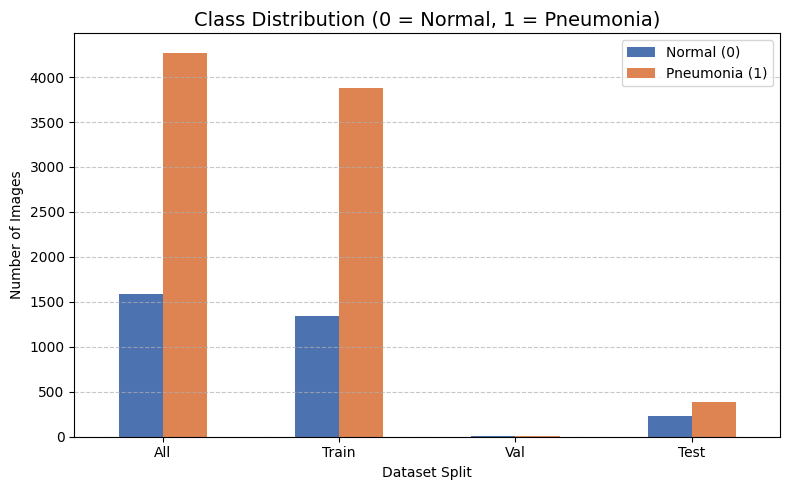

In [115]:
counts_train = df_train_new['label'].value_counts().sort_index()
counts_val = df_val_new['label'].value_counts().sort_index()
counts_test = df_test_new['label'].value_counts().sort_index()
counts_all = df_all_new['label'].value_counts().sort_index()

df_summary = pd.DataFrame({
    'All': counts_all,
    'Train': counts_train,
    'Val': counts_val,
    'Test': counts_test,

}).T.fillna(0).astype(int)

df_summary['Total'] = df_summary[0] + df_summary[1]
df_summary['% Normal (0)'] = (df_summary[0] / df_summary['Total'] * 100).round(1)
df_summary['% Pneumonia (1)'] = (df_summary[1] / df_summary['Total'] * 100).round(1)

print("Class Distribution by Dataset")
display(df_summary)

plt.figure(figsize=(8,5))
df_summary[[0,1]].plot(
    kind='bar',
    stacked=False,
    color=['#4C72B0', '#DD8452'],
    figsize=(8,5)
)
plt.title('Class Distribution (0 = Normal, 1 = Pneumonia)', fontsize=14)
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(['Normal (0)', 'Pneumonia (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [60]:
df_val_old = df_val_new.copy()
df_test_old = df_test_new.copy()
df_train_old = df_train_new.copy()

print("Train:", len(df_train_old))
print("Test:", len(df_test_old))
print("Val:", len(df_val_old))

Train: 5190
Test: 618
Val: 16


In [61]:
target_val = 870
target_test = 870

In [63]:
used_paths = set(df_val_old['filepath']).union(df_test_old['filepath'])
df_remaining = df_train_new[~df_train_new['filepath'].isin(used_paths)]

In [64]:
need_val = target_val - len(df_val_old)
need_test = target_test - len(df_test_old)
need_more = need_val + need_test
print(f"ต้องเพิ่มทั้งหมด {need_more} รูป (โดยเพิ่ม val {need_val} รูป, โดยเพิ่ม test {need_test} รูป)")

ต้องเพิ่มทั้งหมด 1106 รูป (โดยเพิ่ม val 854 รูป, โดยเพิ่ม test 252 รูป)


In [65]:
df_extra, df_train_new = train_test_split(
    df_remaining,
    test_size=(len(df_remaining) - need_more) / len(df_remaining),
    stratify=df_remaining["label"],
    random_state=42
)

df_val_add = df_extra.sample(n=need_val, random_state=42)
df_test_add = df_extra.drop(df_val_add.index).sample(n=need_test, random_state=42)

df_val_new = pd.concat([df_val_old, df_val_add], ignore_index=True)
df_test_new = pd.concat([df_test_old, df_test_add], ignore_index=True)

In [67]:
print("Train:", len(df_train_new))
print("Val:", len(df_val_new))
print("Test:", len(df_test_new))
print("รวมทั้งหมด:", len(df_train_new) + len(df_val_new) + len(df_test_new))

assert len(set(df_val_new['filepath']).intersection(df_test_new['filepath'])) == 0, "มี filepath ซ้ำระหว่าง val/test!"
assert len(set(df_val_new['filepath']).intersection(df_train_new['filepath'])) == 0, "มี filepath ซ้ำระหว่าง val/train!"
assert len(set(df_test_new['filepath']).intersection(df_train_new['filepath'])) == 0, "มี filepath ซ้ำระหว่าง test/train!"

Train: 4084
Val: 870
Test: 870
รวมทั้งหมด: 5824


Class Distribution by Dataset


label     0     1  Total  % Normal (0)  % Pneumonia (1)
All    1579  4245   5824          27.1             72.9
Train  1054  3030   4084          25.8             74.2
Val     224   646    870          25.7             74.3
Test    301   569    870          34.6             65.4

<Figure size 800x500 with 0 Axes>

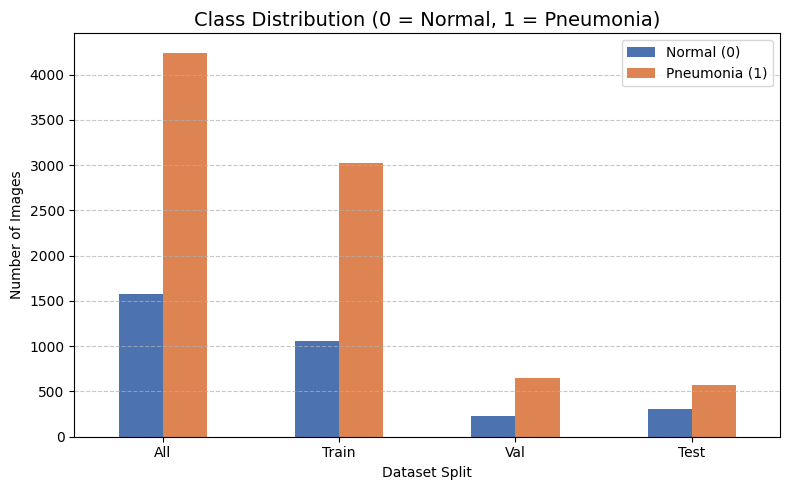

In [68]:
counts_train = df_train_new['label'].value_counts().sort_index()
counts_val = df_val_new['label'].value_counts().sort_index()
counts_test = df_test_new['label'].value_counts().sort_index()
counts_all = df_all_new['label'].value_counts().sort_index()

df_summary = pd.DataFrame({
    'All': counts_all,
    'Train': counts_train,
    'Val': counts_val,
    'Test': counts_test,

}).T.fillna(0).astype(int)

df_summary['Total'] = df_summary[0] + df_summary[1]
df_summary['% Normal (0)'] = (df_summary[0] / df_summary['Total'] * 100).round(1)
df_summary['% Pneumonia (1)'] = (df_summary[1] / df_summary['Total'] * 100).round(1)

print("Class Distribution by Dataset")
display(df_summary)

plt.figure(figsize=(8,5))
df_summary[[0,1]].plot(
    kind='bar',
    stacked=False,
    color=['#4C72B0', '#DD8452'],
    figsize=(8,5)
)
plt.title('Class Distribution (0 = Normal, 1 = Pneumonia)', fontsize=14)
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(['Normal (0)', 'Pneumonia (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


หลังจากที่แบ่งข้อมูลใหม่แล้วจะได้   
Train = 4,084  
Val = 870  
Test = 870  

In [1]:
#สรุปตัวแปรสำหรับเตรียมพร้อม train model
from clean import run_cleaning
from data_split import perform_split
df_train_new, df_val_new, df_test_new = run_cleaning()
df_train_final, df_val_final, df_test_final = perform_split(
    df_train_new,
    df_val_new,
    df_test_new,
    target_val=870,
    target_test=870
)
df_train_new = df_train_final.copy()
df_test_new = df_test_final.copy()
df_val_new = df_val_final.copy()

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🚀 START CLEANING PIPELINE                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 0 — Load DataFrame                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Total files loaded: 5856

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (Cache Found)                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_train.csv

[INFO] Images: 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (Cache Found)                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_val.csv

[INFO] Images: 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (Cache Found)                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_test.csv

[INFO] Images: 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (RGB Cache Found)                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_train.csv

[INFO] Images (RGB): 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (RGB Cache Found)                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_val.csv

[INFO] Images (RGB): 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (RGB Cache Found)                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_test.csv

[INFO] Images (RGB): 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (CLAHE Cache Found)                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_train.csv

[INFO] Images (CLAHE): 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (CLAHE Cache Found)                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_val.csv

[INFO] Images (CLAHE): 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (CLAHE Cache Found)                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_test.csv

[INFO] Images (CLAHE): 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🎉 CLEANING COMPLETE                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Train images: 5190

[INFO] Val images:   16

[INFO] Test images:  618

STEP: Data Split

[INFO] Remaining train images: 5190

[INFO] Need more = 1106 (val 854, test 252)

     SUMMARY     
                 
  Set     Count  
 ─────────────── 
  Train    4084  
  Val       870  
  Test      870  
  Total    5824 

CHECK OVERLAP

✔ No overlaps detected.

## Transforms and Augmentation

ในงาน Image Classification ด้วย PyTorch เราจะใช้ transforms เพื่อจัดการภาพก่อนส่งเข้าโมเดล เช่น Resize, Augmentation, Normalize เป็นต้น   
โดยภาพจะแบ่งออกเป็น 2 กลุ่มหลักคือ RGB และ Grayscale ซึ่งมีขั้นตอนต่างกันเล็กน้อย และแยกอีกทีว่าเป็น NoAug, Aug  

Resize: เนื่องจากโมเดลโครงสร้างส่วนใหญ่ใช้ 224x224 ในการ train ดังนั้นจะต้อง Resize ให้ตรงกับโมเดลที่นำมา Transfer learning  

Feature scaling: 
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

เป็นสถิติ mean และ std ของชุดข้อมูล ImageNet ซึ่งถูกใช้เป็นมาตรฐานสำหรับโมเดลใหญ่ ๆ เช่น ResNet, EfficientNet, ViT  
ทำให้ pixel อยู่ในสเกลใกล้เคียงกัน
ช่วยโมเดล converge เร็วขึ้น
ลดปัญหา gradient แกว่ง
ให้ภาพเข้าโมเดลในรูปแบบเดียวกับตอน pretrain

และในส่วนของ ภาพที่เป็น Grayscale ใช้ mean, std = 0.5 เพราะว่าจาก PyTorch Forum ที่พูดถึง grayscale normalization เพราะ pixel หลัง ToTensor() ถูกสเกลให้อยู่ในช่วง 0 ถึง 1 ซึ่งเป็น range ที่โมเดลเรียนรู้ได้ดีขึ้น


Augmentation  
เนื่องจากมีภาพที่ class ที่เป็นปอดโรคปกติน้อยกว่าภาพปอดอักเสบจะทำการทดลองเพิ่ม Augmentation หมุนภาพเอียงเล็กน้อย แล้ว top up data เดิมเพื่อทำให้ class balance ในส่วนของ train และยังป้องกันให้ model ลด overfitting เนื่องจากมีการเพิ่มภาพลักษณะใหม่ให้โมเดลเรียนรู้

In [4]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# RGB -------------------------------------------------------------------------
train_transform_rgb_aug = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_transform_rgb_noaug = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_test_transform_rgb = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Grayscale -------------------------------------------------------------------
train_transform_gray_aug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transform_gray_noaug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



In [5]:
class XrayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.filepaths = df["filepath"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = torch.tensor(self.labels[idx]).long()
        with Image.open(img_path) as img:
            if self.transform:
                img = self.transform(img)
        return img, label


def balance_dataset_keep_original(df, target_0=3200, target_1=3500):
    df0 = df[df["label"] == 0]
    df1 = df[df["label"] == 1]

    n0, n1 = len(df0), len(df1)
    print(f"Before: class0={n0}, class1={n1} → total={len(df)}")

    add0 = max(target_0 - n0, 0)
    add1 = max(target_1 - n1, 0)

    df0_aug = df0.sample(add0, replace=True, random_state=42) if add0 > 0 else pd.DataFrame(columns=df.columns)
    df1_aug = df1.sample(add1, replace=True, random_state=42) if add1 > 0 else pd.DataFrame(columns=df.columns)

    df0_final = pd.concat([df0, df0_aug])
    df1_final = pd.concat([df1, df1_aug])

    df_balanced = pd.concat([df0_final, df1_final]).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"After : class0={len(df0_final)}, class1={len(df1_final)} → total={len(df_balanced)}")

    return df_balanced



In [6]:
df_train_balanced = balance_dataset_keep_original(df_train_new, target_0=2950, target_1=0)

# -------------------- RGB --------------------
train_ds_rgb_aug     = XrayDataset(df_train_balanced, transform=train_transform_rgb_aug)
train_ds_rgb_noaug   = XrayDataset(df_train_new, transform=train_transform_rgb_noaug)
val_ds_rgb           = XrayDataset(df_val_new, transform=val_test_transform_rgb)
test_ds_rgb          = XrayDataset(df_test_new, transform=val_test_transform_rgb)

# -------------------- Grayscale --------------------
train_ds_gray_aug    = XrayDataset(df_train_balanced, transform=train_transform_gray_aug)
train_ds_gray_noaug  = XrayDataset(df_train_new, transform=train_transform_gray_noaug)
val_ds_gray          = XrayDataset(df_val_new, transform=val_test_transform_gray)
test_ds_gray         = XrayDataset(df_test_new, transform=val_test_transform_gray)


Before: class0=1054, class1=3030 → total=4084
After : class0=2950, class1=3030 → total=5980


<Figure size 800x500 with 0 Axes>

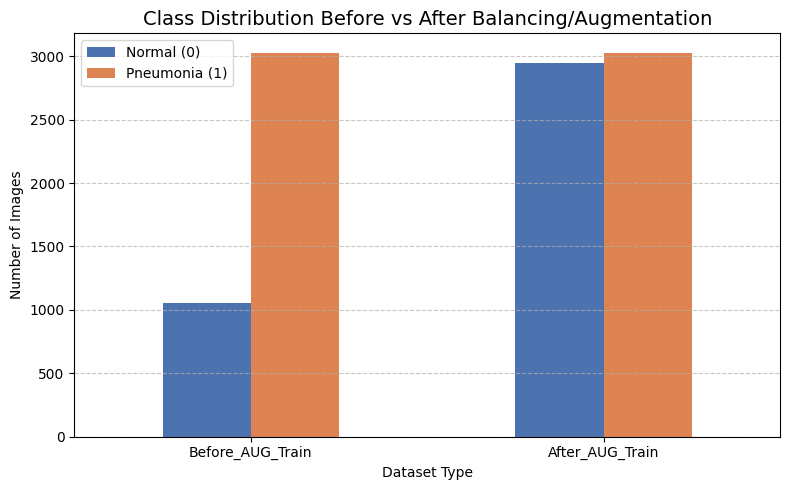

In [7]:
# ---------------- Count before balancing (df_train_new) ----------------
counts_train_before = df_train_new['label'].value_counts().sort_index()

# ---------------- Count after balancing (df_train_balanced) ------------
counts_train_after = df_train_balanced['label'].value_counts().sort_index()

# ---------------- Combine summary table --------------------------------
df_aug_compare = pd.DataFrame({
    'Before_AUG_Train': counts_train_before,
    'After_AUG_Train': counts_train_after
}).T.fillna(0).astype(int)

df_aug_compare['Total'] = df_aug_compare[0] + df_aug_compare[1]

plt.figure(figsize=(8,5))
df_aug_compare[[0,1]].plot(
    kind='bar',
    stacked=False,
    color=['#4C72B0', '#DD8452'],
    figsize=(8,5)
)

plt.title('Class Distribution Before vs After Balancing/Augmentation', fontsize=14)
plt.xlabel('Dataset Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(['Normal (0)', 'Pneumonia (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


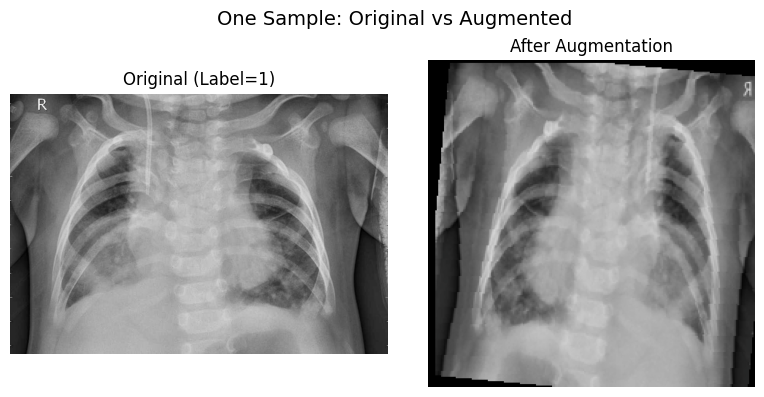

In [8]:
use_rgb = True  
sample = df_train_new.sample(3).iloc[0]
img_path = sample["filepath"]
label = sample["label"]

orig_img = Image.open(img_path)

if use_rgb:
    transform = train_transform_rgb_aug
    mean, std = imagenet_mean, imagenet_std
    orig_img_disp = orig_img.convert("RGB")
else:
    transform = train_transform_gray_aug
    mean, std = [0.5], [0.5]
    orig_img_disp = orig_img.convert("L")

aug_img_tensor = transform(orig_img)
aug_img = aug_img_tensor.clone()

for t, m, s in zip(aug_img, mean, std):
    t.mul_(s).add_(m)
aug_img = torch.clamp(aug_img, 0, 1)
aug_img = aug_img.permute(1, 2, 0).numpy()

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(orig_img_disp, cmap="gray" if not use_rgb else None)
plt.title(f"Original (Label={label})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(aug_img.squeeze(), cmap="gray" if not use_rgb else None)
plt.title("After Augmentation")
plt.axis("off")

plt.suptitle("One Sample: Original vs Augmented", fontsize=14)
plt.tight_layout()
plt.show()


จากภาพด้านซ้ายคือภาพ Original ที่ไม่ได้ Augmentation แล้วทางขวาเป็นภาพที่ถูก Augmentation บีบภาพให้เล็กลงและทำการเอียงภาพเล็กน้อย  

โดยสรุปภาพที่ Augmentation ของ train จากเดิม   
Before: class0=1058, class1=3058, total=4116  
After : class0=3200, class1=3500, total=6700  

## Workflow for traning

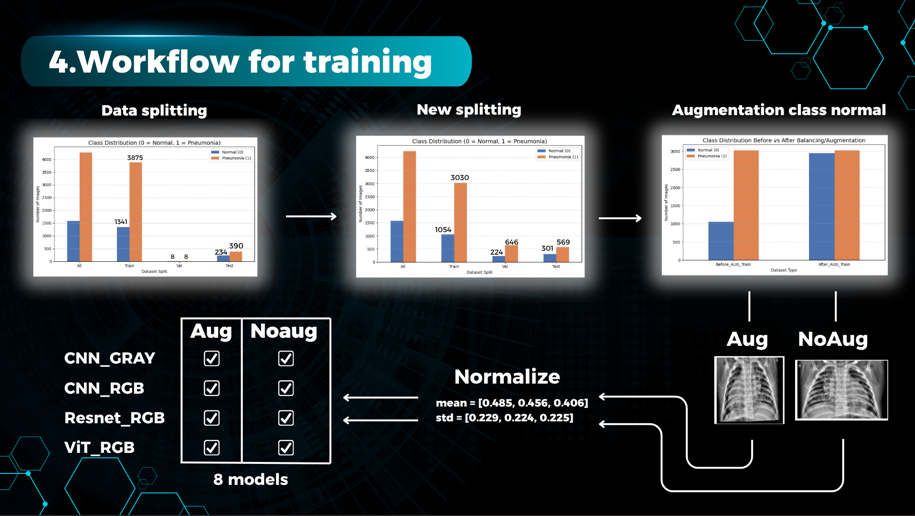

สรุปผลการทดลองทำการ New spilitting เพื่อเพิ่มจำนวนข้อมูลสำหรับ Testset, validationset ให้มีมากกว่าเดิมเพื่อให้ score ดูน่าเชื่อถือมากขึ้นและ ทำการ Augmentation class normal ขึ้นมาให้ class balance แล้ว สรุปมีการทดลอง 8 models  
| ลำดับ | Model ชื่อเต็ม     | ประเภทสี  | Backbone                      | Augmentation |
| ----- | ------------------ | --------- | ----------------------------- | ------------ |
| 1     | **CNN_gray_noaug** | Grayscale | Custom CNN                    | No Aug       |
| 2     | **CNN_gray_aug**   | Grayscale | Custom CNN                    | Aug          |
| 3     | **CNN_RGB_noaug**  | RGB       | Custom CNN                    | No Aug       |
| 4     | **CNN_RGB_aug**    | RGB       | Custom CNN                    | Aug          |
| 5     | **ResNet50_noaug** | RGB       | ResNet50                      | No Aug       |
| 6     | **ResNet50_aug**   | RGB       | ResNet50                      | Aug          |
| 7     | **ViT16_noaug**    | RGB       | Vision Transformer (ViT-B/16) | No Aug       |
| 8     | **ViT16_aug**      | RGB       | Vision Transformer (ViT-B/16) | Aug          |

## Model config

เลือกใช้ Batch_size = 128 เพื่อความเสถียรให้โมเดลปรับ Gradient ได้ smooth มากขึ้นและมีการ shuffle เฉพาะ Train set เนื่องให้แต่ละ epoch ได้เรียนรู้สิ่งที่แตกต่างกัน

In [9]:
batch_size = 128

# --- RGB ---
train_loader_rgb_aug    = DataLoader(train_ds_rgb_aug, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader_rgb_noaug  = DataLoader(train_ds_rgb_noaug, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_rgb          = DataLoader(val_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_rgb         = DataLoader(test_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=0)

# --- Grayscale ---
train_loader_gray_aug   = DataLoader(train_ds_gray_aug, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader_gray_noaug = DataLoader(train_ds_gray_noaug, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_gray         = DataLoader(val_ds_gray, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_gray        = DataLoader(test_ds_gray, batch_size=batch_size, shuffle=False, num_workers=0)

## Inference CNN, Resnet50, ViT from trained

นำโมเดลที่เทรนจาก ไฟล์ .ipynb (CNN,Resnet,ViT) นำมาดูผลของ Testset และวิเคราะห์ว่าโมเดลไหนดีที่สุด

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader):
    y_true, y_pred, y_prob = [], [], []

    model.eval()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)


            if logits.shape[1] == 1:
                prob = torch.sigmoid(logits).cpu().numpy().flatten()
                pred = (prob > 0.5).astype(int)

            else:
                soft = torch.softmax(logits, dim=1).cpu().numpy()
                prob = soft[:, 1]                # probability of class 1
                pred = np.argmax(soft, axis=1)   # predicted class

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(pred)
            y_prob.extend(prob)

    return np.array(y_true), np.array(y_pred), np.array(y_prob)




In [ ]:
model_colors = {
    "CNN_Gray_AUG":    "#1F77B4",   # Bright Blue
    "CNN_Gray_NOAUG":  "#2CA02C",   # Bright Green
    "CNN_RGB_AUG":     "#FF7F0E",   # Orange
    "CNN_RGB_NOAUG":   "#9467BD",   # Purple

    "ResNet_aug":      "#D62728",   # Bright Red
    "ResNet_noaug":    "#E377C2",   # Pink

    "ViT_aug":         "#F1C40F",   # Gold 
    "ViT_noaug":       "#B7950B",   # Dark Gold
}


In [12]:
def plot_confusion_matrix(y_true, y_pred, title, model_name):
    cm = confusion_matrix(y_true, y_pred)
    base_color = model_colors[model_name]
    cmap = sns.light_palette(base_color, as_cmap=True)

    plt.figure(figsize=(4,3.5))
    sns.heatmap(cm, annot=True, cmap=cmap, fmt="d",
                xticklabels=["Normal", "Pneumonia"],
                yticklabels=["Normal", "Pneumonia"])
    plt.title(title, fontsize=12)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


def plot_roc_single(y_true, y_prob, title, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(4.5,4))
    plt.plot(fpr, tpr, color=model_colors[model_name],
             label=f"AUC={roc_auc:.3f}", linewidth=2)
    plt.plot([0,1],[0,1],'k--')
    plt.title(title, fontsize=12)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

โหลดโมเดล

In [13]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

class TinyCNN_Gray(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(16*56*56, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)


class TinyCNN_RGB(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(16*56*56, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)


def build_resnet50():
    model = resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model

def build_vit():
    model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
    model.heads.head = nn.Linear(model.heads.head.in_features, 1)
    return model


In [14]:
def load_checkpoint(model, ckpt_path):

    try:
        ckpt = torch.load(
            ckpt_path,
            map_location=device,
            weights_only=False  # safe mode
        )
    except TypeError:
        ckpt = torch.load(
            ckpt_path,
            map_location=device
        )


    if isinstance(ckpt, nn.Module):
        print(f"[INFO] Loaded FULL MODEL from {ckpt_path}")
        return ckpt.to(device)

    elif isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        print(f"[INFO] Loaded state_dict from {ckpt_path}")
        model.load_state_dict(ckpt["model_state_dict"])
        return model.to(device)

    else:
        raise ValueError(f"Unknown checkpoint format: {ckpt_path}")


In [15]:
models = {
    # ==========================
    # CNN Models
    # ==========================
    "CNN_Gray_AUG": {
        "model": TinyCNN_Gray(),
        "ckpt": "best_model_gray_aug.pth",
        "loader": test_loader_gray
    },
    "CNN_Gray_NOAUG": {
        "model": TinyCNN_Gray(),
        "ckpt": "best_model_gray_noaug.pth",
        "loader": test_loader_gray
    },
    "CNN_RGB_AUG": {
        "model": TinyCNN_RGB(),
        "ckpt": "best_model_rgb_aug.pth",
        "loader": test_loader_rgb
    },
    "CNN_RGB_NOAUG": {
        "model": TinyCNN_RGB(),
        "ckpt": "best_model_rgb_noaug.pth",
        "loader": test_loader_rgb
    },

    # ==========================
    # ResNet50 Models
    # ==========================
    "ResNet_aug": {
        "model": build_resnet50(),
        "ckpt": "ResNet50_aug.pt",
        "loader": test_loader_rgb
    },
    "ResNet_noaug": {
        "model": build_resnet50(),
        "ckpt": "ResNet50_noaug.pt",
        "loader": test_loader_rgb
    },

    # ==========================
    # NEW: VIT MODELS
    # ==========================
    "ViT_aug": {
        "model": build_vit(),
        "ckpt": "ViT_aug.pt",
        "loader": test_loader_rgb
    },
    "ViT_noaug": {
        "model": build_vit(),
        "ckpt": "ViT_noaug.pt",
        "loader": test_loader_rgb
    },
}


for name, info in models.items():
    print(f"Loading {name} ...")
    info["model"] = load_checkpoint(info["model"], info["ckpt"])



Loading CNN_Gray_AUG ...
[INFO] Loaded state_dict from best_model_gray_aug.pth
Loading CNN_Gray_NOAUG ...
[INFO] Loaded state_dict from best_model_gray_noaug.pth
Loading CNN_RGB_AUG ...
[INFO] Loaded state_dict from best_model_rgb_aug.pth
Loading CNN_RGB_NOAUG ...
[INFO] Loaded state_dict from best_model_rgb_noaug.pth
Loading ResNet_aug ...
[INFO] Loaded FULL MODEL from ResNet50_aug.pt
Loading ResNet_noaug ...
[INFO] Loaded FULL MODEL from ResNet50_noaug.pt
Loading ViT_aug ...
[INFO] Loaded FULL MODEL from ViT_aug.pt
Loading ViT_noaug ...
[INFO] Loaded FULL MODEL from ViT_noaug.pt


In [16]:
results = {}

for name, info in models.items():
    print(f"\nEvaluating {name} ...")
    y_true, y_pred, y_prob = evaluate_model(info["model"], info["loader"])
    results[name] = {"y_true": y_true, "y_pred": y_pred, "y_prob": y_prob}


Evaluating CNN_Gray_AUG ...

Evaluating CNN_Gray_NOAUG ...

Evaluating CNN_RGB_AUG ...

Evaluating CNN_RGB_NOAUG ...

Evaluating ResNet_aug ...

Evaluating ResNet_noaug ...

Evaluating ViT_aug ...

Evaluating ViT_noaug ...



CNN_Gray_AUG

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.905     0.694     0.786       301
           1      0.856     0.961     0.906       569

    accuracy                          0.869       870
   macro avg      0.880     0.828     0.846       870
weighted avg      0.873     0.869     0.864       870



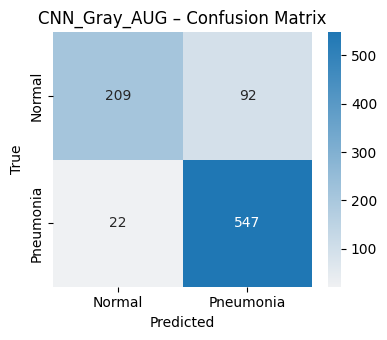


CNN_Gray_NOAUG

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.963     0.515     0.671       301
           1      0.794     0.989     0.881       569

    accuracy                          0.825       870
   macro avg      0.878     0.752     0.776       870
weighted avg      0.852     0.825     0.808       870



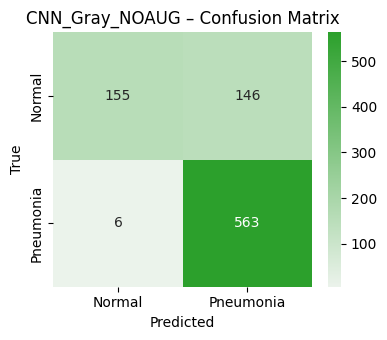


CNN_RGB_AUG

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.897     0.608     0.725       301
           1      0.823     0.963     0.887       569

    accuracy                          0.840       870
   macro avg      0.860     0.786     0.806       870
weighted avg      0.849     0.840     0.831       870



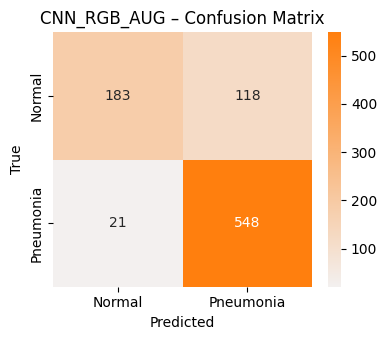


CNN_RGB_NOAUG

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.960     0.561     0.709       301
           1      0.810     0.988     0.890       569

    accuracy                          0.840       870
   macro avg      0.885     0.775     0.799       870
weighted avg      0.862     0.840     0.827       870



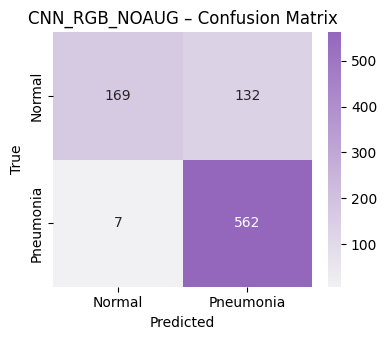


ResNet_aug

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.907     0.681     0.778       301
           1      0.851     0.963     0.904       569

    accuracy                          0.866       870
   macro avg      0.879     0.822     0.841       870
weighted avg      0.870     0.866     0.860       870



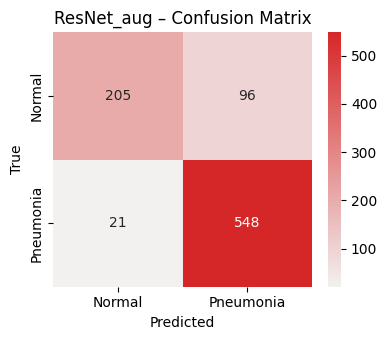


ResNet_noaug

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.932     0.641     0.760       301
           1      0.837     0.975     0.901       569

    accuracy                          0.860       870
   macro avg      0.885     0.808     0.830       870
weighted avg      0.870     0.860     0.852       870



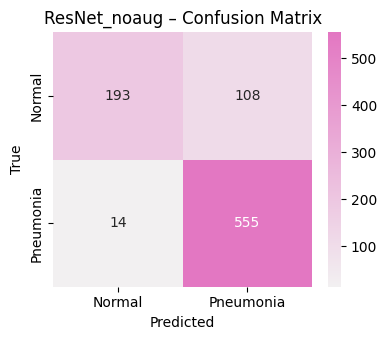


ViT_aug

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.926     0.794     0.855       301
           1      0.899     0.967     0.931       569

    accuracy                          0.907       870
   macro avg      0.913     0.880     0.893       870
weighted avg      0.908     0.907     0.905       870



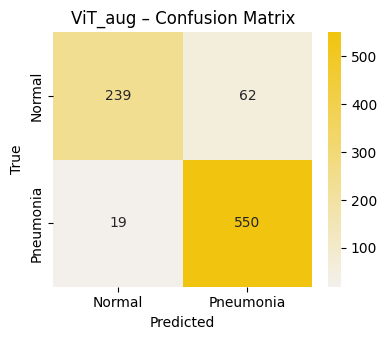


ViT_noaug

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.937     0.641     0.761       301
           1      0.837     0.977     0.902       569

    accuracy                          0.861       870
   macro avg      0.887     0.809     0.832       870
weighted avg      0.872     0.861     0.853       870



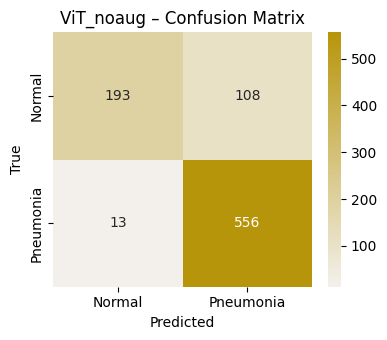

In [17]:
for name, res in results.items():

    print("\n=================================")
    print(name)
    print("=================================\n")

    # --- Safety check ---
    if not all(k in res for k in ["y_true", "y_pred", "y_prob"]):
        print(f"[ERROR] Missing keys in results[{name}], skip...")
        continue

    if len(res["y_true"]) == 0:
        print(f"[ERROR] Empty predictions for {name}, skip...")
        continue

    if name not in model_colors:
        print(f"[ERROR] No color defined for {name}, skip plots...")
        continue

    # --- Classification Report ---
    print("=== Classification Report ===")
    print(classification_report(res["y_true"], res["y_pred"], digits=3))

    # --- Confusion Matrix ---
    plot_confusion_matrix(
        res["y_true"], res["y_pred"],
        f"{name} – Confusion Matrix",
        model_name=name
    )



1) CNN_Gray_AUG
   
ดีตรง Recall class 1 สูงมาก (0.961) จับ Pneumonia ดี    
แต่ Recall class 0 ต่ำ (0.694) ผิด Normal เยอะ    
 
2) CNN_Gray_NOAUG 
   
Recall class 1 สูงที่สุด (0.989) แทบไม่พลาด Pneumonia   
แต่ Recall class 0 แย่ (0.515) Normal โดนทำนายผิดครึ่งหนึ่ง   
โมเดล overfit ฝั่ง pneumonia ชัดเจน    
    
3) CNN_RGB_AUG   
 
Balanced กว่าแบบ Gray   
Recall class 1 = 0.963, class 0 = 0.608   
ยัง bias ไปที่ Pneumonia แต่ดีกว่า Gray_NOAUG   

4) CNN_RGB_NOAUG 

ใช้งานได้ แต่ผลกลางๆ   
ยัง bias similar to CNN รุ่นอื่นๆ Pneumonia ดีกว่า Normal   

5) ResNet_noaug 
 
Strong model overall   
Recall class 1 = 0.975 (ดีมาก)   
Recall class 0 = 0.641 (ยังต่ำ)   
ยังสะท้อนปัญหาเดิม Pneumonia heavy prediction   

6) ViT_aug

โมเดลที่ดีที่สุดในกลุ่มทั้งหมด   
Recall class 1 = 0.967 (สูง)   
Recall class 0 = 0.794 (สูงที่สุดในกลุ่ม)   
Accuracy = 0.907 (สูงสุด)   
ฟอร์มดีทั้งสอง class ทำได้ดีที่สุดแบบสมดุล   

7) ViT_noaug   
  
ดีใกล้เคียง ResNet_noaug   
Recall class 1 = 0.977   
Recall class 0 = 0.641   
ยัง bias ไปทาง Pneumonia เหมือน ResNet   

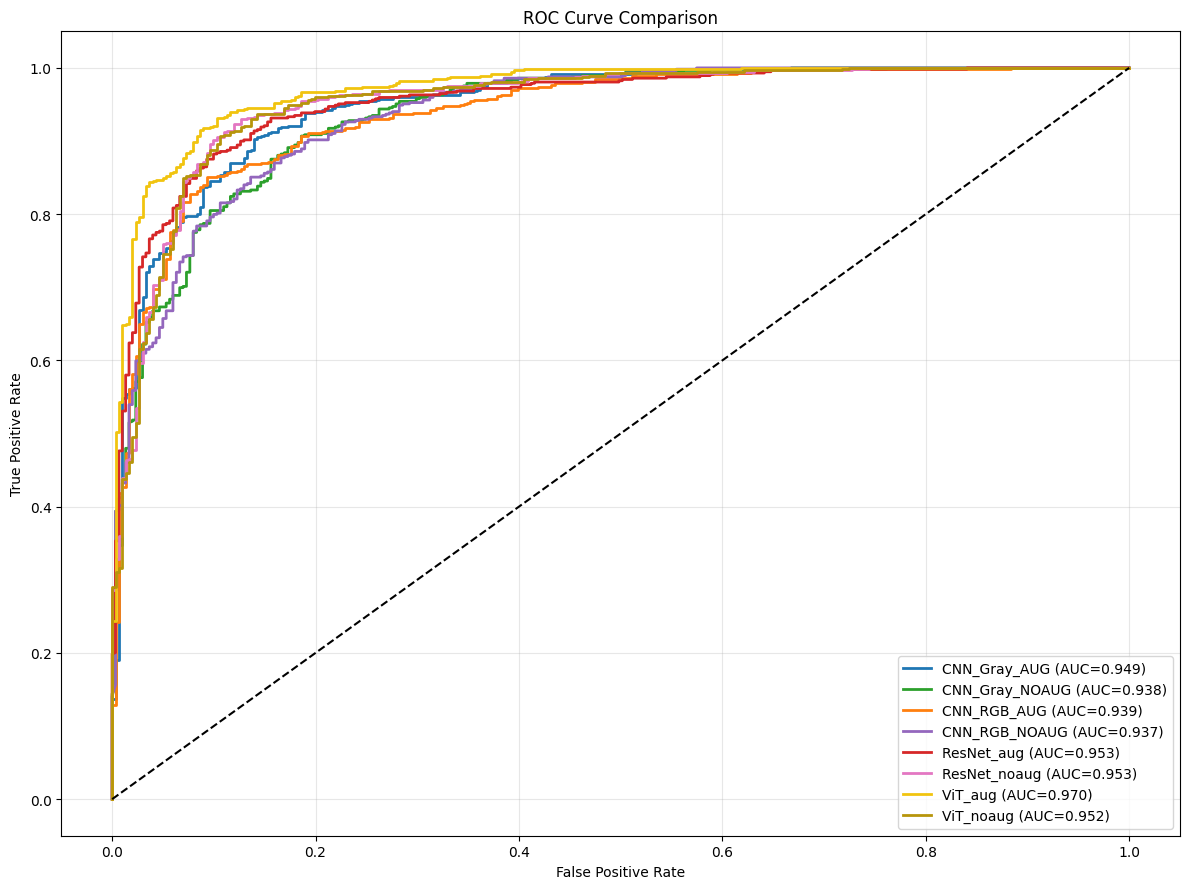

In [18]:
plt.figure(figsize=(12,9))

for name, res in results.items():
    fpr, tpr, _ = roc_curve(res["y_true"], res["y_prob"])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr,
             label=f"{name} (AUC={roc_auc:.3f})",
             color=model_colors[name],
             linewidth=2)

plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


กราฟนี้แสดงความสามารถของโมเดลทั้งหมดในการแยกภาพปอดปกติและปอดอักเสบ โดยดูจากค่า AUC (ยิ่งใกล้ 1 ยิ่งดี)  
ภาพรวมมีประเด็นสำคัญดังนี้:   

1) ViT_aug ทำผลงานดีที่สุด  
เส้น ROC ของ ViT_aug อยู่สูงกว่าทุกโมเดลในแทบทุกช่วงของกราฟ และให้ค่า AUC ประมาณ 0.970 ซึ่งถือว่าสูงที่สุดในชุดทั้งหมด แสดงว่าโมเดลนี้แยกแยะภาพได้แม่นที่สุดและเสถียรที่สุด  
 
2) ResNet และ ViT_noaug ทำผลงานใกล้เคียงกันและอยู่ในกลุ่มระดับสูง  
ทั้ง ResNet_aug, ResNet_noaug และ ViT_noaug มีค่า AUC ประมาณ 0.952–0.953 ซึ่งถือว่าดีมาก และเส้น ROC อยู่ในระดับสูงค่อนข้างนิ่ง แสดงว่าโมเดลกลุ่มนี้มีประสิทธิภาพสูงใกล้เคียงกัน  
  
3) โมเดลตระกูล CNN อยู่ในระดับรองลงมา  
CNN ทุกแบบมีค่า AUC ประมาณ 0.937–0.949 แม้จะไม่แย่ แต่ก็ยังต่ำกว่า ViT และ ResNet โดยเฉพาะช่วงต้นของกราฟ (บริเวณ FPR ต่ำ) โมเดล CNN จะแยกแยะได้ไม่ดีเท่าโมเดลที่ใหญ่กว่า  
  
4) เส้น ROC ของหลายโมเดลทับกัน  
เหตุผลเพราะโมเดลหลายตัวมีประสิทธิภาพใกล้กัน จึงทำให้เส้นบางช่วงแทบซ้อนกัน ซึ่งเป็นเรื่องปกติเมื่อโมเดลทำงานได้ใกล้เคียงกันในหลาย threshold    

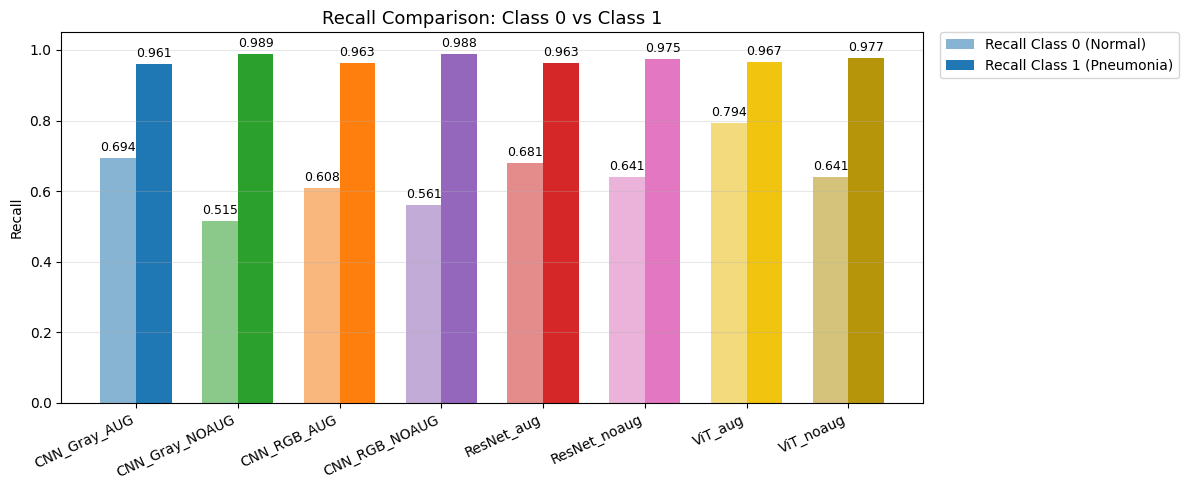

In [ ]:

model_names = []
recall_0 = []
recall_1 = []
colors = []

for name, res in results.items():
    model_names.append(name)

    # recall class 0 และ class 1
    recall_0.append(recall_score(res["y_true"], res["y_pred"], pos_label=0))
    recall_1.append(recall_score(res["y_true"], res["y_pred"], pos_label=1))

    colors.append(model_colors[name])

# ------------------------------
# Plot grouped bar chart
# ------------------------------
x = np.arange(len(model_names))
width = 0.35 

plt.figure(figsize=(12,5))

# bar ของ class 0
plt.bar(x - width/2, recall_0, width, label="Recall Class 0 (Normal)", 
        color=[sns.light_palette(c, n_colors=5)[2] for c in colors])

# bar ของ class 1
plt.bar(x + width/2, recall_1, width, label="Recall Class 1 (Pneumonia)",
        color=[sns.light_palette(c, n_colors=5)[4] for c in colors])

plt.xticks(x, model_names, rotation=25, ha="right")
plt.ylim(0, 1.05)
plt.title("Recall Comparison: Class 0 vs Class 1", fontsize=13)
plt.ylabel("Recall")
plt.grid(axis="y", alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
for i in range(len(model_names)):
    plt.text(x[i] - width/2, recall_0[i] + 0.02, f"{recall_0[i]:.3f}", ha="center", fontsize=9)
    plt.text(x[i] + width/2, recall_1[i] + 0.02, f"{recall_1[i]:.3f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


ผลลัพธ์จากกราฟ Recall แสดงให้เห็นว่าโมเดลแบบ NOAUG แม้จะมี Recall ของ Pneumonia สูงมาก แต่เกิดจากความลำเอียงของโมเดลที่ทำนายว่า “เป็นโรค” เกือบทุกครั้ง เนื่องจากข้อมูลฝึกมีความหลากหลายไม่มากพอ ทำให้โมเดลเรียนรู้สัญญาณจำเพาะของคลาส Pneumonia แบบผิดทาง และไม่เข้าใจลักษณะของภาพปอดปกติอย่างแท้จริง จึงให้ผลลวงจำนวนมากและ Recall ของคลาส Normal ต่ำอย่างเห็นได้ชัด

เมื่อใช้ augmentation โมเดลได้เรียนรู้จากข้อมูลที่หลากหลายขึ้น ทั้งในมุมมอง แสง และรูปแบบ ทำให้ decision boundary มีความสมดุลกว่าและไม่ลำเอียงไปทางการวินิจฉัยว่าเป็นโรคอย่างเดียว ผลคือ Recall ของคลาส Normal ดีขึ้นมาก ในขณะที่ Recall ของ Pneumonia ยังคงอยู่ในระดับสูง โดยเฉพาะ ViT_aug ซึ่งมีทั้งความแม่นยำและความสมดุลที่ดีที่สุด จึงเหมาะที่สุดสำหรับการใช้งานจริง

ในภาพรวม ViT_aug เป็นโมเดลที่ให้ผลดีที่สุด เพราะมีความสมดุลระหว่างทั้งสองคลาสอย่างชัดเจน Recall ของ Normal สูงกว่าโมเดลอื่นมาก ขณะที่ Recall ของ Pneumonia ก็ยังอยู่ในระดับสูง ทำให้ ViT_aug เป็นตัวเลือกที่เหมาะสมที่สุดสำหรับการใช้งานจริง เนื่องจากให้ความแม่นยำที่ดีทั้งในการตรวจพบโรคและการลดการเตือนผิดในผู้ป่วยปกติ

## Error analysis (ViT aug bestmodel)

In [20]:
vit_model = models["ViT_aug"]["model"]
vit_loader = models["ViT_aug"]["loader"]

y_true = results["ViT_aug"]["y_true"]
y_pred = results["ViT_aug"]["y_pred"]
y_prob = results["ViT_aug"]["y_prob"]


In [21]:
FN_idx = np.where((y_true == 1) & (y_pred == 0))[0]

FP_idx = np.where((y_true == 0) & (y_pred == 1))[0]

print("FN (missed pneumonia):", len(FN_idx))
print("FP (false alarm):", len(FP_idx))


FN (missed pneumonia): 19
FP (false alarm): 62


In [22]:
FN_idx = np.where((y_true == 1) & (y_pred == 0))[0]   # True=1, Pred=0
FP_idx = np.where((y_true == 0) & (y_pred == 1))[0]   # True=0, Pred=1

print("FN =", len(FN_idx))
print("FP =", len(FP_idx))

FN = 19
FP = 62


In [23]:
dataset = vit_loader.dataset

FN_paths = [dataset.filepaths[i] for i in FN_idx]
FP_paths = [dataset.filepaths[i] for i in FP_idx]


In [24]:
import cv2
import matplotlib.pyplot as plt

def show_images(paths, title, max_images=12):
    plt.figure(figsize=(12, 10))
    for i, path in enumerate(paths[:max_images]):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.title(f"{title}\n{os.path.basename(path)}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


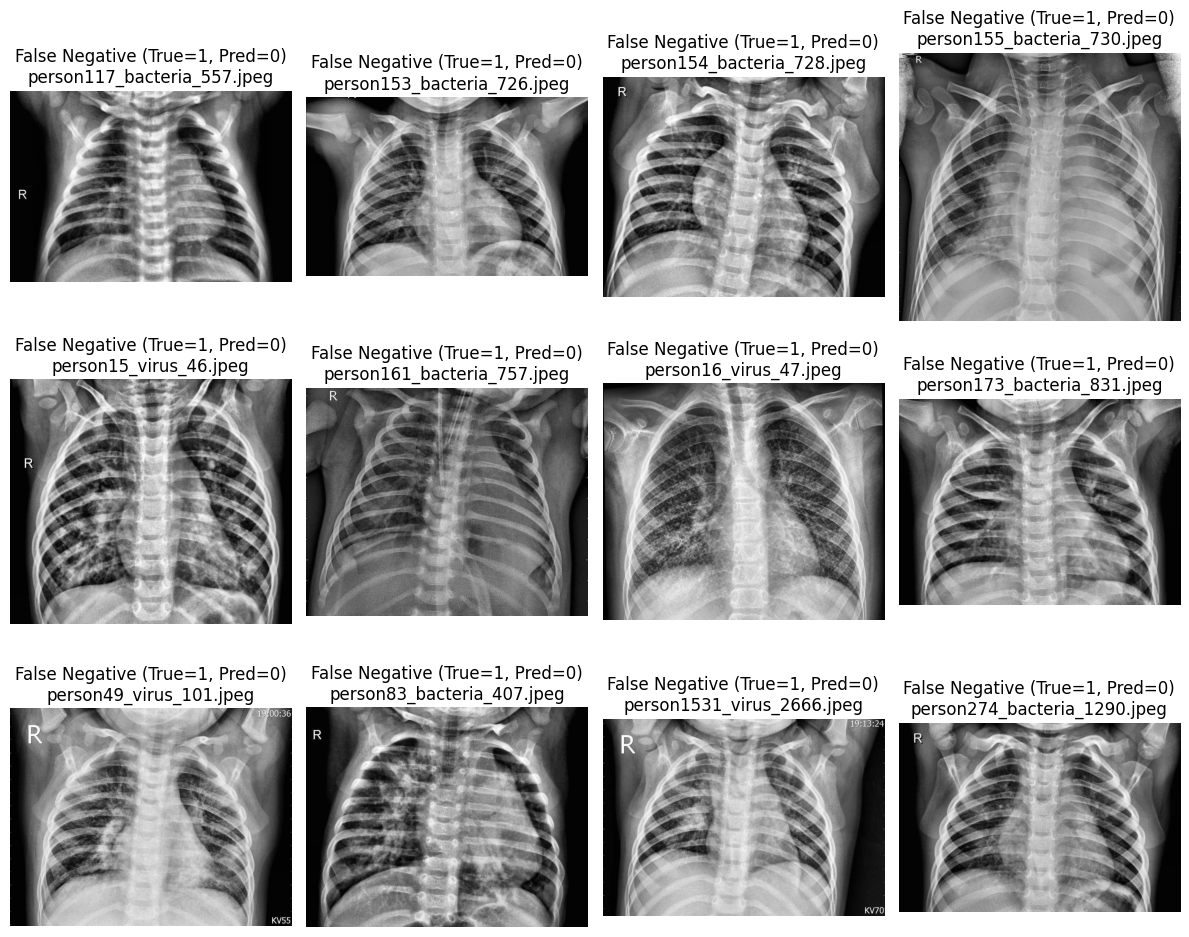

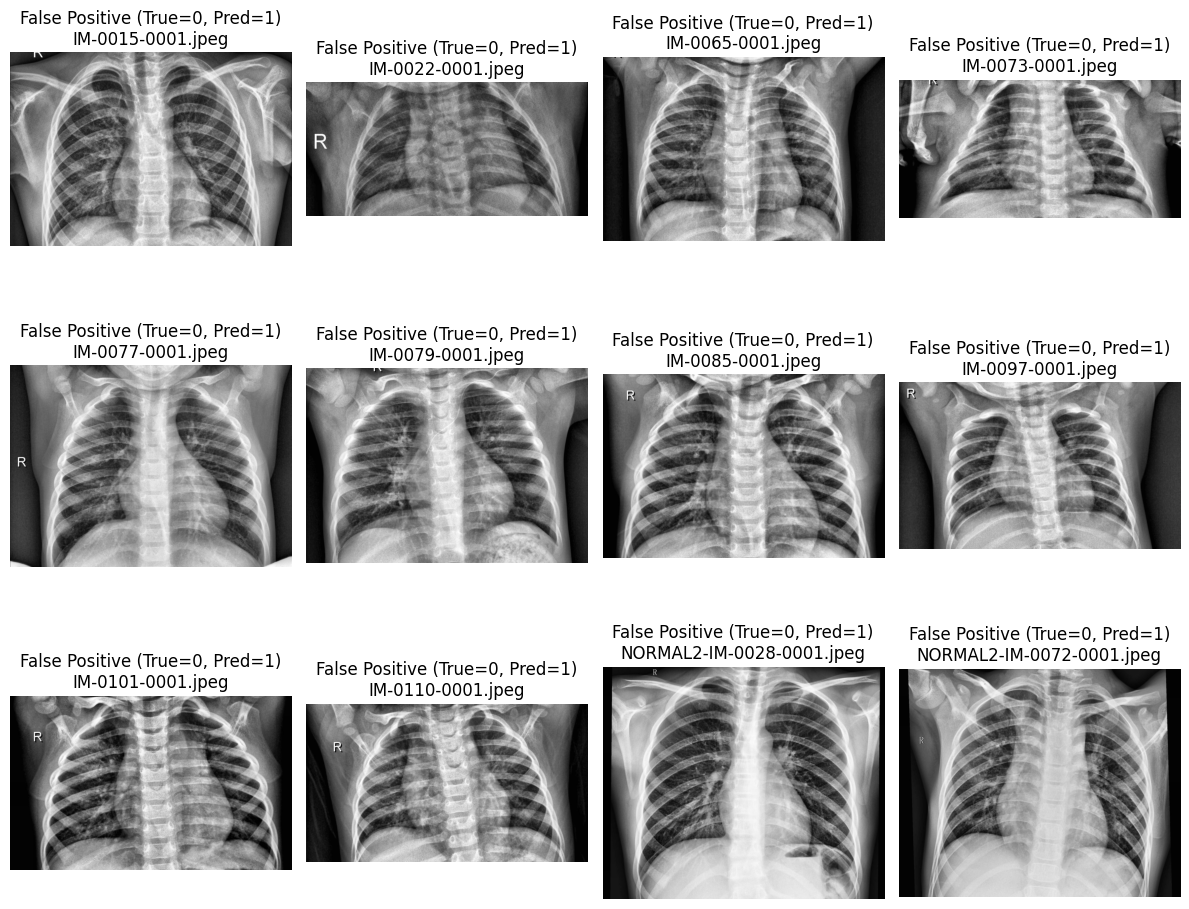

In [25]:
show_images(FN_paths, "False Negative (True=1, Pred=0)")
show_images(FP_paths, "False Positive (True=0, Pred=1)")


จากตัวอย่างภาพ FN จะเห็นว่าภาพส่วนใหญ่มีลักษณะที่ทำให้การวินิจฉัยยากขึ้น เช่น ภาพที่มืดหรือคอนทราสต์ต่ำจนลักษณะของลอยโรคไม่ชัดเจน รวมถึงบางภาพที่มีลักษณะฝ้าในปอดหรือความหนาแน่นแบบกระจายที่ดูคล้ายภาพปอดอักเสบจากไวรัสมากกว่าการติดเชื้อแบคทีเรีย ซึ่งเป็น pattern ที่แยกจาก Normal ไม่ง่ายแม้สำหรับมนุษย์ ภาพบางชุดยังมี artifact เช่น ความเบลอหรือประทับสัญลักษณ์ที่บดบังบางส่วนของภาพ ซึ่งมีผลให้โมเดลไม่เห็นจุดที่ควรสนใจ

และจากตัวอย่างภาพ FP จะเห็นว่าภาพส่วนใหญ่เป็นปอดปกติแต่มีความเข้มลายเส้นเลือดหรือ pattern บางอย่างที่ดู “คล้าย” กับภาพปอดอักเสบแบบอ่อน ๆ เช่น ความเข้มบริเวณ perihilar, ลักษณะ hazy radiopacity บางตำแหน่ง หรือความแตกต่างของแสงที่ทำให้ภาพดูไม่เท่ากัน โมเดล ViT_aug จึงตีความว่าเป็น Pneumonia ทั้งที่จริงเป็น Normal เพราะเส้นลายหรือคอนทราสต์บางแบบไปทับซ้อนกับ pattern ที่โมเดลเคยเห็นในภาพโรค โดยเฉพาะภาพไวรัสหรือภาพปอดที่มีความเข้มเป็นหย่อม ๆ ซึ่งเป็นรูปแบบที่แยกยากแม้สำหรับมนุษย์ บางภาพก็มี artifact เช่นอักษร “R”, เงาขอบซี่โครง หรือ overexposure/underexposure ทำให้ texture คล้ายโรคมากขึ้น

แนวทางพัฒนาต่อคือควรให้ผู้เชี่ยวชาญเฉพาะทางช่วยรีวิวว่าแต่ละภาพมีลักษณะเฉพาะอะไร เช่น ฝ้าที่กระจายแบบไวรัส การมืดสว่างไม่สม่ำเสมอ หรือสัญญาณรอยโรคที่จางมาก เพื่อใช้เป็นข้อมูลในการออกแบบ preprocessing ให้โมเดลเห็น pattern เหล่านี้ได้เด่นขึ้น เช่น การปรับความสว่าง-คอนทราสต์ การลด noise การทำ enhancement เฉพาะบริเวณปอด หรือพัฒนาการทำ augmentation ตามจุดอ่อนจริงที่พบ การทำเช่นนี้จะช่วยลด FN และทำให้โมเดลมองเห็นสัญญาณที่ซ่อนอยู่ได้ดีขึ้นในขั้นถัดไป.

## Feature importance

เพื่อดูใน ViT โมเดลสนใจ pixel ไหนเป็นพิเศษ เพื่อดูว่าโมเดลจับ noise มั้ยแล้วเราจะพัฒนาโมเดลให้เก่งขึ้นได้อย่างไร

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = torch.load("ViT_aug.pt", map_location=device,weights_only=False)
vit_model.eval()
vit_model.to(device)

print("Loaded ViT_aug.pt")

Loaded ViT_aug.pt


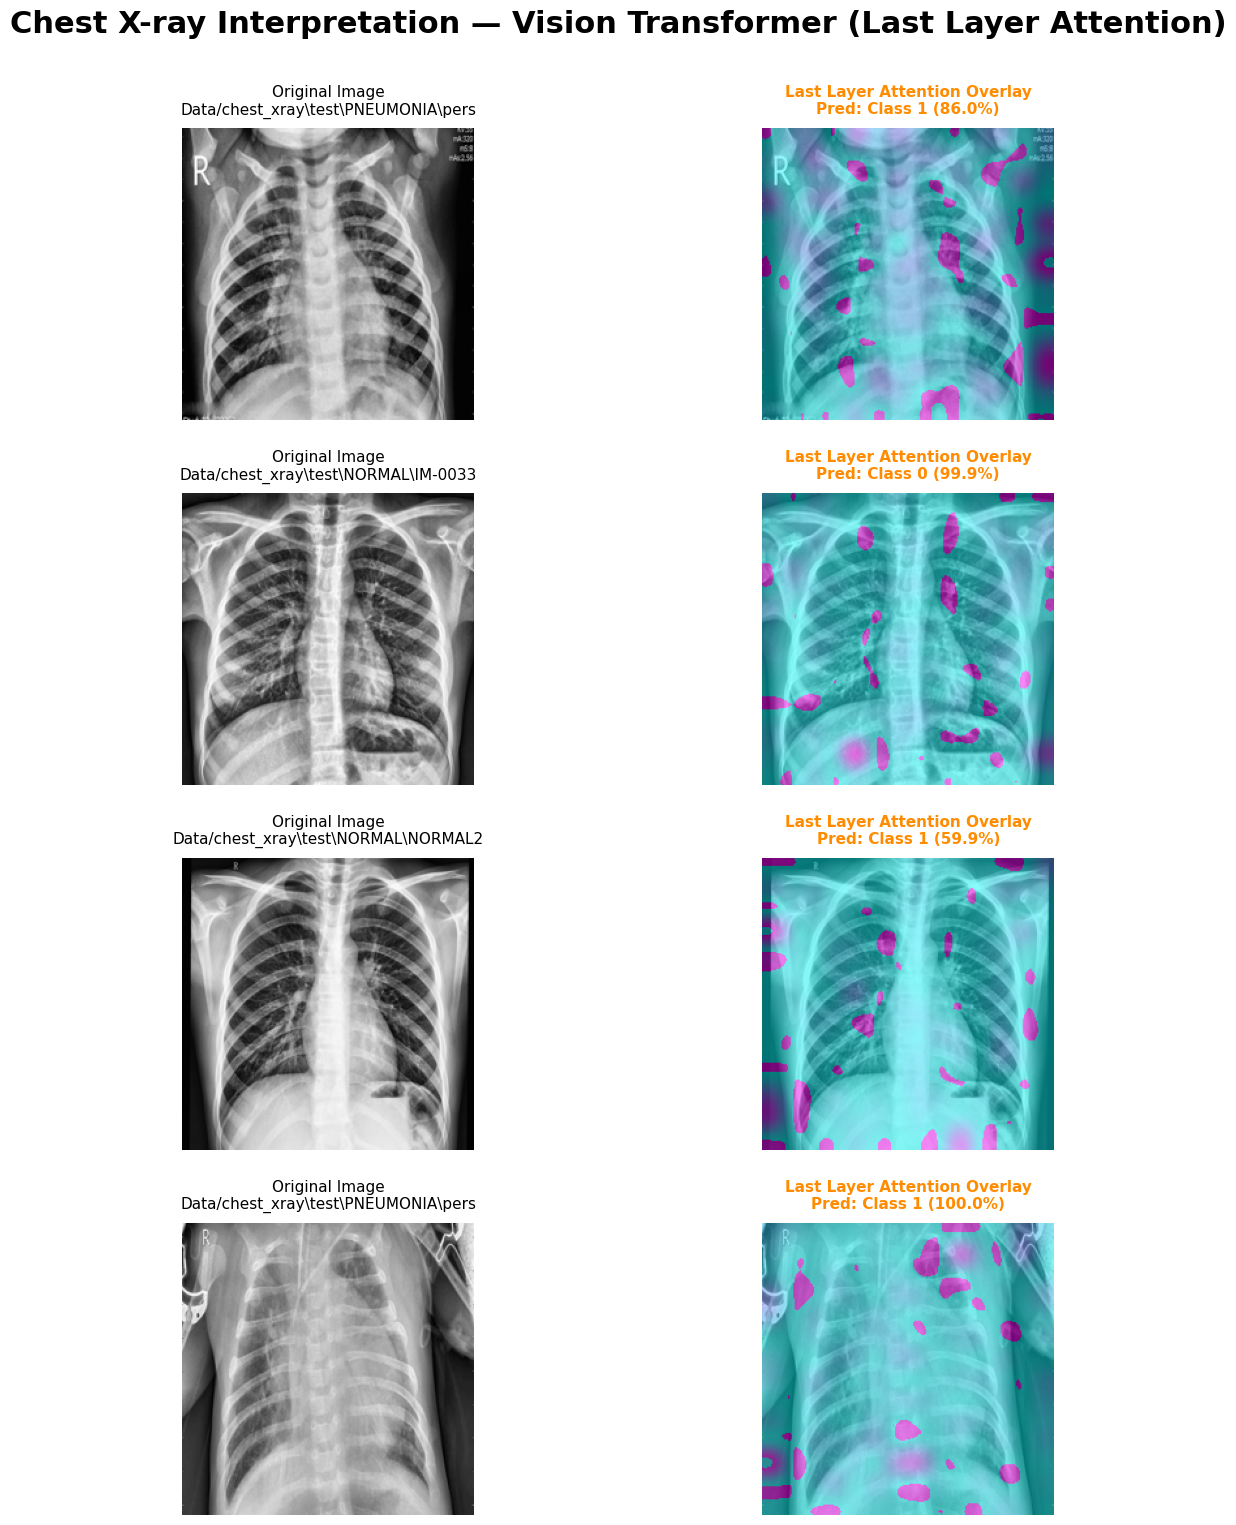

In [ ]:
# -------------------------- Setup --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = torch.load("ViT_aug.pt", map_location=device, weights_only=False)
vit_model.eval().to(device)

def patched_forward(self, query, key, value, **kwargs):
    kwargs["need_weights"] = True
    kwargs["average_attn_weights"] = False
    return nn.MultiheadAttention.forward(self, query, key, value, **kwargs)

for m in vit_model.modules():
    if isinstance(m, nn.MultiheadAttention):
        m.forward = patched_forward.__get__(m)

attn_weights = []
def save_attn(m, i, o): 
    attn_weights.append(o[1].detach().cpu())

handles = [
    m.register_forward_hook(save_attn)
    for m in vit_model.modules()
    if isinstance(m, nn.MultiheadAttention)
]

def get_last_layer_cam(x):
    attn_weights.clear()
    with torch.no_grad():
        _ = vit_model(x)

    cam = attn_weights[-1][0].mean(0)[0, 1:]      
    cam = cam.reshape(14, 14).cpu().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    return cam

def make_overlay(img_np, cam):
    cam_resized = cv2.resize(cam, (224, 224), interpolation=cv2.INTER_CUBIC)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_COOL)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img_np, 0.55, heatmap, 0.45, 0)
    return overlay

transform = test_loader_rgb.dataset.transform
paths = random.sample(list(test_loader_rgb.dataset.filepaths), 4)

plt.figure(figsize=(14, 16))   
plt.suptitle("Chest X-ray Interpretation — Vision Transformer (Last Layer Attention)", 
             fontsize=22, fontweight='bold', y=0.95)

for idx, path in enumerate(paths):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    img_np = np.array(img.resize((224, 224)))

    with torch.no_grad():
        logits = vit_model(x)
        prob = torch.softmax(logits, dim=1)
        pred_idx = prob.argmax(1).item()
        pred_conf = prob[0, pred_idx].item()
        pred_label = test_loader_rgb.dataset.classes[pred_idx] if hasattr(test_loader_rgb.dataset, 'classes') else f"Class {pred_idx}"

    cam = get_last_layer_cam(x)
    overlay = make_overlay(img_np, cam)

    short_name = f"{path.split('/')[-2]}/{path.split('/')[-1].split('.')[0][:30]}"

    plt.subplot(4, 2, 2*idx + 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f"Original Image\n{short_name}", fontsize=11, pad=10)

    plt.subplot(4, 2, 2*idx + 2)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f"Last Layer Attention Overlay\nPred: {pred_label} ({pred_conf:.1%})", 
              fontsize=11, pad=10, color='darkorange', fontweight='semibold')

plt.tight_layout(rect=[0, 0, 1, 0.94])  
plt.subplots_adjust(hspace=0.25)
plt.show()

for h in handles: 
    h.remove()


จากการแสดงผล Last Layer Attention บนภาพ X-ray พบว่าโมเดล Vision Transformer สามารถระบุบริเวณที่มีสัญญาณความผิดปกติได้ระดับหนึ่ง โดยในภาพที่เป็น Pneumonia จุดสนใจของโมเดลมักปรากฏบริเวณที่มีรอยฝ้า (opacity) หรือบริเวณที่มีความขุ่นของเนื้อปอด ซึ่งเป็นตำแหน่งที่สัมพันธ์กับโรคจริง ส่วนภาพที่เป็น Normal การกระจายของจุดสนใจไม่รวมตัวเป็นพื้นที่เด่นชัดและกระจายตัวมากกว่า ซึ่งสอดคล้องกับการที่ไม่มีรอยโรคเฉพาะเจาะจงให้แบบจำลองตรวจจับ

อย่างไรก็ตาม จุดสนใจที่เกิดขึ้นบางส่วนยังพบว่าปรากฏในบริเวณที่ไม่ใช่โครงสร้างปอด เช่น บริเวณขอบภาพหรืออวัยวะอื่น ซึ่งอาจเป็นสัญญาณว่าโมเดลยังไวต่อ noise หรือ pattern ที่ไม่เกี่ยวกับโรค ทำให้การตีความยังมีความไม่เสถียรในบางกรณี

โมเดลอาจกำลังใช้สัญญาณที่ไม่เกี่ยวกับรอยโรค เช่น noise บริเวณขอบภาพ จึงควรเพิ่มขั้นตอน preprocessing เช่น cropping บริเวณ lung field หรือลบส่วนเกินของภาพ
ควรใช้เทคนิคที่กำกับตำแหน่งปอด เช่น lung segmentation ก่อนเข้าสู่โมเดล เพื่อบังคับให้ attention กระจุกอยู่ในบริเวณที่มีความหมายทางคลินิกมากขึ้น

## Summary 

จากการทดสอบโมเดลทั้งหมด 8 โมเดล ได้แก่ 
| ลำดับ | Model ชื่อเต็ม     | ประเภทสี  | Backbone                      | Augmentation |
| ----- | ------------------ | --------- | ----------------------------- | ------------ |
| 1     | **CNN_gray_noaug** | Grayscale | Custom CNN                    | No Aug       |
| 2     | **CNN_gray_aug**   | Grayscale | Custom CNN                    | Aug          |
| 3     | **CNN_RGB_noaug**  | RGB       | Custom CNN                    | No Aug       |
| 4     | **CNN_RGB_aug**    | RGB       | Custom CNN                    | Aug          |
| 5     | **ResNet50_noaug** | RGB       | ResNet50                      | No Aug       |
| 6     | **ResNet50_aug**   | RGB       | ResNet50                      | Aug          |
| 7     | **ViT16_noaug**    | RGB       | Vision Transformer (ViT-B/16) | No Aug       |
| 8     | **ViT16_aug**      | RGB       | Vision Transformer (ViT-B/16) | Aug          |

พบว่ากลุ่มโมเดลแบบ no augmentation มีแนวโน้มเกิดอคติ (bias) ต่อคลาส “ป่วย” ทำให้แม้ recall    จะสูง   แต่สร้าง false alarm มากเกินไป ซึ่งไม่เหมาะสมกับการใช้งานจริงในงานคัดกรองผู้ป่วยเบื้องต้น  
เมื่อเพิ่ม augmentation เพื่อให้ข้อมูลสมดุลขึ้น โมเดลทุกตัวมีพฤติกรรมที่ดีขึ้น โดยเฉพาะ ViT_aug ซึ่งให้ผลดีที่สุดทั้งด้าน recall และความแม่นยำโดยรวม  

| Metric    | Class 0 (Normal) | Class 1 (Pneumonia) |
| --------- | ---------------- | ------------------- |
| Precision | 0.926            | 0.899               |
| Recall    | 0.794            | 0.967               |
| F1-score  | 0.855            | 0.931               |


สรุปคือโมเดลสามารถตรวจจับ Pneumonia ได้ดีมาก (recall ~97%)   
แต่ recall ของคลาส Normal ยังต่ำกว่าเล็กน้อย ซึ่งบ่งชี้ว่ามี false positive บางส่วน

Next Steps (อิงจาก Feature Importance)

ลดผลกระทบจาก noise / artifact เพราะ attention พบว่าโมเดลยังโฟกัสบริเวณที่ไม่ใช่   
lung field เช่น ขอบภาพ ตัวอักษร R/L หรือแสงสะท้อน ควรเพิ่ม preprocessing   
เช่น crop ปอดด้วย lung segmentation เพื่อตัดส่วนที่ไม่จำเป็นออก   

เสริมข้อมูล Normal ให้หลากหลายขึ้น  
Feature importance ชี้ว่าคลาส Normal มีความแปรปรวนสูง ทำให้โมเดลสับสน ควรเพิ่ม augmentation  
ฝั่ง Normal เช่น brightness/contrast/blur เพื่อให้โมเดลแยก Normal ที่คุณภาพไม่ดีออกจาก Pneumonia ได้ดีขึ้น